# Six-Way Controller Comparison: Cart-Pole System

Comparing:
1. Augmented Dynamic Compensator
2. Residual MLP: u = -Kx + MLP(x)
3. Pure MLP: u = MLP(x)
4. Residual LSTM: u = -Kx + LSTM(x)
5. Pure LSTM: u = LSTM(x)


## Setup and Imports

In [1]:
# Mount Google Drive for saving/loading models and figures
from google.colab import drive
drive.mount('/content/drive')

# Create directories for outputs
import os
BASE_DIR = '/content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL'
MODELS_DIR = os.path.join(BASE_DIR, 'models')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
ANIMATIONS_DIR = os.path.join(BASE_DIR, 'animations')

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(ANIMATIONS_DIR, exist_ok=True)

print(f"Outputs will be saved to: {BASE_DIR}")
print(f"  - Models: {MODELS_DIR}")
print(f"  - Figures: {FIGURES_DIR}")
print(f"  - Animations: {ANIMATIONS_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Outputs will be saved to: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL
  - Models: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL/models
  - Figures: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL/figures
  - Animations: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL/animations


In [2]:
!pip install torch torchdiffeq matplotlib numpy scipy

In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## System Definition

In [4]:
# Physical parameters
params = {
    'M': 1.0,    # Cart mass (kg)
    'm': 0.3,    # Pendulum mass (kg)
    'L': 0.5,    # Pendulum length (m)
    'g': 9.81,   # Gravity (m/s^2)
    'b': 0.1     # Cart friction (N/(m/s))
}

# Augmented system dimensions
STATE_DIM = 4          # x = [x_cart, x_dot_cart, theta, theta_dot]
CONTROL_DIM = 1        # u (scalar force on cart)
Q_DIM_COMPLEX = 5      # Number of complex eigenvalues for q dynamics
Q_DIM = 2 * Q_DIM_COMPLEX  # Total real dimension (real + imaginary parts)



print(f"State dimension: {STATE_DIM}")
print(f"Control dimension: {CONTROL_DIM}")
print(f"Complex auxiliary state dimension: {Q_DIM_COMPLEX}")
print(f"Real auxiliary state dimension: {Q_DIM}")

State dimension: 4
Control dimension: 1
Complex auxiliary state dimension: 5
Real auxiliary state dimension: 10


In [5]:
def f(x, params):
    """
    Drift dynamics: f(x)
    x = [x_cart, x_dot_cart, theta, theta_dot]
    """
    M, m, L, g, b = params['M'], params['m'], params['L'], params['g'], params['b']

    x_pos = x[..., 0]
    x_dot = x[..., 1]
    theta = x[..., 2]
    theta_dot = x[..., 3]

    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)

    # Denominator for dynamics
    denom = M + m * sin_theta**2

    # Cart acceleration (without control input)
    x_ddot = (m * L * theta_dot**2 * sin_theta - b * x_dot - m * g * sin_theta * cos_theta) / denom

    # Pendulum angular acceleration (without control input)
    theta_ddot = (-(m * L * theta_dot**2 * sin_theta * cos_theta) +
                  b * x_dot * cos_theta +
                  (M + m) * g * sin_theta) / (L * denom)

    return torch.stack([x_dot, x_ddot, theta_dot, theta_ddot], dim=-1)

def g(x, params):
    """
    Control influence: g(x)
    Returns the matrix that multiplies the control input u
    """
    M, m, L = params['M'], params['m'], params['L']

    theta = x[..., 2]
    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)

    denom = M + m * sin_theta**2

    # Control influence on cart acceleration
    g_x_ddot = 1.0 / denom

    # Control influence on pendulum angular acceleration
    g_theta_ddot = -cos_theta / (L * denom)

    # g(x) returns [0, g_x_ddot, 0, g_theta_ddot]
    zeros = torch.zeros_like(g_x_ddot)
    return torch.stack([zeros, g_x_ddot, zeros, g_theta_ddot], dim=-1)

In [6]:
def compute_linearization(params):
    """
    Compute A and B matrices by linearizing around the upright equilibrium (x=0)
    """
    M, m, L, g, b = params['M'], params['m'], params['L'], params['g'], params['b']

    # A matrix (4x4)
    A = np.array([
        [0, 1, 0, 0],
        [0, -b/M, -m*g/M, 0],
        [0, 0, 0, 1],
        [0, b/(M*L), (M+m)*g/(M*L), 0]
    ])

    # B matrix (4x1)
    B = np.array([
        [0],
        [1/M],
        [0],
        [-1/(M*L)]
    ])

    return A, B

def lqr(A, B, Q, R):
    """
    Solve the continuous-time LQR problem.
    Returns the optimal gain matrix K such that u = -Kx
    """
    from scipy.linalg import solve_continuous_are

    # Solve the Algebraic Riccati Equation
    P = solve_continuous_are(A, B, Q, R)

    # Compute the LQR gain
    K = np.linalg.inv(R) @ B.T @ P

    return K, P

# Compute linearization
A, B = compute_linearization(params)

print("A matrix:")
print(A)
print("\nB matrix:")
print(B)

# Design LQR controller
Q = np.diag([10.0, 1.0, 100.0, 1.0])  # State cost
R = np.array([[0.1]])                   # Control cost

K, P = lqr(A, B, Q, R)

print("\nLQR Gain K:")
print(K)

# Check stability
A_cl = A - B @ K
eigenvalues = np.linalg.eigvals(A_cl)
print("\nClosed-loop eigenvalues:")
print(eigenvalues)
print("\nSystem is stable:", np.all(np.real(eigenvalues) < 0))

# Convert K to torch tensor
K_torch = torch.tensor(K, dtype=torch.float32, device=device)

A matrix:
[[ 0.     1.     0.     0.   ]
 [ 0.    -0.1   -2.943  0.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.     0.2   25.506  0.   ]]

B matrix:
[[ 0.]
 [ 1.]
 [ 0.]
 [-2.]]

LQR Gain K:
[[-10.         -11.79680442 -74.95096714 -14.92879136]]

Closed-loop eigenvalues:
[-7.76179436+3.23048012j -7.76179436-3.23048012j -1.3185948 +1.0184017j
 -1.3185948 -1.0184017j ]

System is stable: True


## Network Architectures

In [7]:
class MLPNoBias(nn.Module):
    """
    Multi-layer perceptron with NO bias terms.
    Ensures that MLP(0) = 0.
    """
    def __init__(self, input_dim, output_dim, hidden_dim=8, num_layers=2):
        super(MLPNoBias, self).__init__()

        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim, bias=False))
        layers.append(nn.Softplus(15.0))

        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim, bias=False))
            layers.append(nn.Softplus(15.0))

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim, bias=False))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class MLPWithBias(nn.Module):
    """
    Multi-layer perceptron WITH bias terms.
    Used for initialization networks (MLP1, MLP3) to allow non-zero outputs even with zero input.
    """
    def __init__(self, input_dim, output_dim, hidden_dim=8, num_layers=2):
        super(MLPWithBias, self).__init__()

        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim, bias=True))
        layers.append(nn.Softplus(15.0))

        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim, bias=True))
            layers.append(nn.Softplus(15.0))

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim, bias=True))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [8]:
class AugmentedControllerSystem(nn.Module):
    def __init__(self, params, K, q_dim_complex=5, hidden_dim=8, num_layers=2):
        super(AugmentedControllerSystem, self).__init__()

        self.params = params
        self.K = K
        self.state_dim = STATE_DIM
        self.q_dim_complex = q_dim_complex  # Number of complex eigenvalues
        self.q_dim = 2 * q_dim_complex      # Real dimension (real + imag parts)
        # learnable projection B: maps (state_dim) -> (q_dim)
        self.B_q = nn.Parameter(torch.randn(self.q_dim, self.state_dim, device=device) * 0.1)
        self.actuator_gain = nn.Parameter(torch.tensor(100.0, device=device))  # >1 to amplify



        # Lambda_xi: diagonal matrix with negative real eigenvalues
        self.lambda_xi_diag = nn.Parameter(torch.ones(self.state_dim, device=device) * (-0.5))

        # Lambda_q: Parameters for complex eigenvalues
        # Each complex eigenvalue is: lambda = real_part + i * imag_part
        # For stability: real_part < 0, imag_part != 0 (for oscillations)
        self.lambda_q_real = nn.Parameter(torch.ones(self.q_dim_complex, device=device) * (-0.5))
        self.lambda_q_imag = nn.Parameter(torch.ones(self.q_dim_complex, device=device) * 1.0)

        # MLP networks
        # MLP1 (WITH bias): x0 -> xi(0)  [state_dim -> state_dim]
        self.mlp1_xi_init = MLPWithBias(self.state_dim, self.state_dim, hidden_dim, num_layers).to(device)

        # MLP2 (NO bias): (x-xi) -> contribution to q_dot  [state_dim -> q_dim (full, real+imag)]
        self.mlp2_q_dynamics = MLPNoBias(self.state_dim, self.q_dim, hidden_dim, num_layers).to(device)

        # MLP3 (WITH bias): x0 -> q(0)  [state_dim -> q_dim (full, real+imag)]
        self.mlp3_q_init = MLPWithBias(self.state_dim, self.q_dim, hidden_dim, num_layers).to(device)


                # ---------- __init__ ----------
        # after self.mlp3_q_init = ...
        self.q0_scale = nn.Parameter(torch.ones(self.q_dim, device=device) * 5.0)
        # optional: prefer Re channels initially larger
        with torch.no_grad():
            self.q0_scale[0::2] = 5.0  # boost Re(q) initial magnitude

        # ---------- compute_initial_conditions ----------
        def compute_initial_conditions(self, x0):
            xi0 = x0 + self.mlp1_xi_init(x0)
            q0 = self.mlp3_q_init(x0)
            # apply broadcasted per-dim learnable scale
            q0 = q0 * self.q0_scale.unsqueeze(0)
            return xi0, q0

        # MLP4 (NO bias): [Re(q), x-xi] -> control correction  [(q_dim_complex + state_dim) -> control_dim]
        # Only uses REAL part of q!
        self.mlp4_control = MLPNoBias(self.q_dim_complex + self.state_dim, CONTROL_DIM, hidden_dim, num_layers).to(device)

    def get_lambda_xi(self):
        """Returns Lambda_xi as a diagonal matrix (enforcing negative values)"""
        return torch.diag(-torch.abs(self.lambda_xi_diag))

    def get_lambda_q(self):
        """
        Returns Lambda_q as a real matrix with complex eigenvalues.
        For a complex eigenvalue lambda = a + bi, the corresponding 2x2 block is:
        [a  -b]
        [b   a]

        This acts on [Re(q_i), Im(q_i)]^T
        """
        # Ensure real parts are negative (stability)
        real_parts = -torch.abs(self.lambda_q_real)
        imag_parts = self.lambda_q_imag

        # Build block diagonal matrix
        blocks = []
        for i in range(self.q_dim_complex):
            a = real_parts[i]
            b = imag_parts[i]
            block = torch.tensor([[a, -b], [b, a]], device=device)
            blocks.append(block)

        # Create block diagonal matrix
        Lambda_q = torch.block_diag(*blocks)
        return Lambda_q

    def compute_initial_conditions(self, x0):
        """
        Compute initial conditions for xi and q given x0
        xi(0) = x(0) + MLP1(x0)
        q(0) = MLP3(x0)  [returns full q including real and imaginary parts]
        """
        xi0 = x0 + self.mlp1_xi_init(x0)
        q0 = self.mlp3_q_init(x0)
        return xi0, q0

    def compute_control(self, x, xi, q):
        """
        Compute control: u = -K*xi + MLP4(Re(q), x-xi)

        Note: q is structured as [Re(q_1), Im(q_1), Re(q_2), Im(q_2), ...]
        So Re(q) = q[0::2] extracts every other element starting from 0
        """
        # Base controller: -K*xi
        u_base = -torch.matmul(xi, self.K.T).squeeze(-1)

        # Extract real parts of q (indices 0, 2, 4, ...)
        # q is structured as: [Re(q1), Im(q1), Re(q2), Im(q2), Re(q3), Im(q3), ...]
        q_real = q[..., 0::2]  # Take every other element starting from index 0

        # Neural network correction: MLP4([Re(q), x-xi])
        x_minus_xi = x - xi
        mlp_input = torch.cat([q_real, x_minus_xi], dim=-1)




        u_correction = self.actuator_gain * self.mlp4_control(mlp_input).squeeze(-1)

        u = u_base + u_correction
        return u

    def forward(self, t, state):
        """
        Compute derivatives for the augmented system.
        state = [x, xi, q] concatenated along last dimension
        q contains both real and imaginary parts: [Re(q), Im(q)] interleaved
        """
        # Split the augmented state
        x = state[..., :self.state_dim]
        xi = state[..., self.state_dim:2*self.state_dim]
        q = state[..., 2*self.state_dim:]

        # Compute control (uses only Re(q))
        u = self.compute_control(x, xi, q)

        # Compute f(x) and g(x)
        f_x = f(x, self.params)
        g_x = g(x, self.params)

        # x_dot = f(x) + g(x)u
        x_dot = f_x + g_x * u.unsqueeze(-1)

        # xi_dot = f(x) - Lambda_xi*(x-xi) + g(x)u
        Lambda_xi = self.get_lambda_xi()
        x_minus_xi = x - xi
        xi_dot = f_x - torch.matmul(x_minus_xi, Lambda_xi.T) + g_x * u.unsqueeze(-1)

        # q_dot = Lambda_q * q + MLP2(x-xi)
                # q_dot = Lambda_q * q + Gamma * B * (x - xi)
        Lambda_q = self.get_lambda_q()                          # (q_dim x q_dim)
        # build gamma vector: |real_part| repeated for real+imag parts
        gamma_vec = torch.abs(self.lambda_q_real).repeat_interleave(2)  # (q_dim,)

        # compute B*(x-xi): x_minus_xi has shape (..., state_dim)
        Bx = torch.matmul(x_minus_xi, self.B_q.T)               # (..., q_dim)

        # apply Gamma as elementwise scaling (repeat_interleave already matched order)
        GammaBx = gamma_vec.unsqueeze(0) * Bx                   # (..., q_dim)

        q_dot = torch.matmul(q, Lambda_q.T) + GammaBx           # (..., q_dim)

        #q_dot = torch.matmul(q, Lambda_q.T) + #+ self.mlp2_q_dynamics(x_minus_xi)

        # Concatenate derivatives
        state_dot = torch.cat([x_dot, xi_dot, q_dot], dim=-1)

        return state_dot

## Training All Controllers

All five controllers will be trained in sequence with identical hyperparameters and NaN handling.

### 1. Augmented Dynamic Compensator

In [9]:
# ============================================================
# MULTI-SEED TRAINING: Augmented Controller
# Training 5 times with different seeds
# ============================================================
# Training seeds
SEEDS = [111, 123, 456, 789, 43]
NUM_SEEDS = len(SEEDS)

# Storage for all seeds
aug_models_all_seeds = {}
aug_loss_history_all_seeds = {}

print("="*60)
print("TRAINING AUGMENTED DYNAMIC COMPENSATOR")
print(f"Training with {NUM_SEEDS} different seeds: {SEEDS}")
print("="*60)

for seed_idx, seed in enumerate(SEEDS):
    print(f"\n{'='*60}")
    print(f"SEED {seed_idx+1}/{NUM_SEEDS}: {seed}")
    print(f"{'='*60}\n")

    import torch
    import torch.optim as optim
    from collections import deque

    # Set seed for reproducibility
    SEED = seed  # Using current seed from loop
    NUM_EPOCHS = 300
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)

    # Obstacle parameters (fixed)
    OBSTACLE_RADIUS = 0.1
    OBSTACLE_CENTER = -1.5
    OBSTACLE_CENTER2 = -2
    OBSTACLE_CENTER2_y = 0.4
    OBSTACLE_DSAFE  = 0.05  # dsafe from the problem statement


    def obstacle_penalty(x_traj):
        """
        x_traj: tensor (..., STATE_DIM) with [x_cart, x_dot, theta, theta_dot].
        Returns: tensor (...) with the obstacle penalty for each state.

        Geometry:
          - hinge at (x_cart, 0)
          - tip at (x_cart + L*sin(theta), L*cos(theta))
          - obstacle: circle centered at (-1, L) with radius R=0.2
        """
        L = params['L']

        x_cart = x_traj[..., 0]
        theta  = x_traj[..., 2]

        # Tip position
        x_tip = x_cart + L * torch.sin(theta)
        y_tip = L * torch.cos(theta)

        # Obstacle center
        x_o = OBSTACLE_CENTER
        y_o = L

        x_o2 = OBSTACLE_CENTER2
        y_o2 = OBSTACLE_CENTER2_y

        dx = x_tip - x_o
        dy = y_tip - y_o
        d  = torch.sqrt(dx * dx + dy * dy + 1e-12)  # avoid NaNs at d=0

        dx2 = x_tip - x_o2
        dy2 = y_tip - y_o2
        d2  = torch.sqrt(dx2 * dx2 + dy2 * dy2 + 1e-12)  # avoid NaNs at d=0

        R      = OBSTACLE_RADIUS
        dsafe  = OBSTACLE_DSAFE
        R_safe = R + dsafe

        # Initialize cost
        cost = torch.zeros_like(d)

        # Region 1: far from obstacle, d >= R_safe -> cost = 0  (already default)

        # Region 2: near boundary but outside, R <= d < R_safe -> quadratic
        mask_near = (d >= R) & (d < R_safe)
        cost_near = (R_safe - d)**2

        mask_near2 = (d2 >= R) & (d2 < R_safe)
        cost_near2 = (R_safe - d2)**2

        cost = cost + cost_near * mask_near + cost_near2 * mask_near2

        # Region 3: inside obstacle, d < R -> exponential in penetration depth
        mask_in      = d < R
        mask_in2      = d2 < R

        base_inside  = dsafe**2            # ensures continuity at d = R
        kappa        = 20.0                # controls how fast exponential grows
        beta         = 1.0
        cost_inside  = base_inside + beta * (torch.exp(kappa * (R - d)) - 1.0)
        cost_inside2  = base_inside + beta * (torch.exp(kappa * (R - d2)) - 1.0)
        cost = cost + cost_inside * mask_in + cost_inside2 * mask_in2

        return cost


    # Make sure we are on the same device as the rest of the notebook
    print(f"Training on device: {device}")

    # Create a fresh augmented system for training
    aug_system_train = AugmentedControllerSystem(
        params=params,
        K=K_torch,
        q_dim_complex=Q_DIM_COMPLEX,
        hidden_dim=32,
        num_layers=4
    ).to(device)

    # Optimizer over all parameters
    initial_lr = 5e-3
    optimizer = optim.Adam(aug_system_train.parameters(), lr=initial_lr)

    # Time horizon and sampling for odeint
    T_final = 5.0
    N_steps = 200
    t_span = torch.linspace(0.0, T_final, N_steps, device=device)

    # =====================================================
    # INITIAL CONDITION SAMPLING WITH NOISE
    # =====================================================

    batch_size = 16          # training batch size
    noise_std = 0.05          # std of Gaussian perturbation

    # Base IC: cart = -2, others = 0
    x0_base = torch.zeros(batch_size, STATE_DIM, device=device)
    x0_base[:, 0] = -2.0

    # Add Gaussian noise
    x0_noisy = x0_base + noise_std * torch.randn_like(x0_base)

    # Quadratic state cost weight (no control penalty for now, keep it minimal)
    Q_state = 0.1
    OBSTACLE_WEIGHT = 50.0  # relative weight of the obstacle penalty in the running cost

    def rollout_and_cost(model):
        # Compute xi0, q0 for the **batch** of noisy initial conditions
        xi0, q0 = model.compute_initial_conditions(x0_noisy)
        aug_state0 = torch.cat([x0_noisy, xi0, q0], dim=-1)

        traj = odeint(model, aug_state0, t_span, method='rk4')   # (N_steps, batch, total_dim)
        x_traj = traj[:, :, :STATE_DIM]

        dt = T_final / (N_steps - 1)

        # Quadratic state cost ||x||^2
        x_sq = (x_traj ** 2).sum(dim=-1)  # (N_steps, batch)

        # Obstacle penalty based on tip position vs circle
        obs_cost = obstacle_penalty(x_traj)  # (N_steps, batch)

        # Combined running cost
        stage_cost = Q_state * x_sq + OBSTACLE_WEIGHT * obs_cost  # (N_steps, batch)

        # Average over batch, integrate over time
        cost = (stage_cost.mean(dim=1) * dt).sum()   # scalar

        # average across batch → integrate over time → scalar
        total_state = ( (Q_state * x_sq).mean(dim=1) * dt ).sum()
        total_obs   = ( (OBSTACLE_WEIGHT * obs_cost).mean(dim=1) * dt ).sum()

        return cost, total_state, total_obs, x_traj


    def save_model_state(model):
        """Save current model parameters to CPU"""
        return {name: param.clone().detach().cpu() for name, param in model.named_parameters()}


    def load_model_state(model, state_dict):
        """Restore model parameters from saved state"""
        for name, param in model.named_parameters():
            param.data.copy_(state_dict[name].to(param.device))


    # =====================================================
    # IMPROVED NaN RECOVERY STRATEGY
    # =====================================================

    class SafeStateBuffer:
        """Maintains a rolling buffer of the last N safe model states"""
        def __init__(self, buffer_size=5):
            self.buffer = deque(maxlen=buffer_size)
            self.buffer_size = buffer_size

        def add(self, state_dict, loss_value):
            """Add a safe state with its loss value"""
            self.buffer.append({
                'state': state_dict,
                'loss': loss_value
            })

        def get_best(self):
            """Return the state with lowest loss from buffer"""
            if not self.buffer:
                return None
            best_entry = min(self.buffer, key=lambda x: x['loss'])
            return best_entry['state']

        def get_oldest(self):
            """Return the oldest state in buffer (most conservative choice)"""
            if not self.buffer:
                return None
            return self.buffer[0]['state']

        def get_median(self):
            """Return the middle state (by age) from buffer"""
            if not self.buffer:
                return None
            mid_idx = len(self.buffer) // 2
            return self.buffer[mid_idx]['state']

        def is_full(self):
            """Check if buffer has reached its maximum size"""
            return len(self.buffer) == self.buffer_size

        def __len__(self):
            return len(self.buffer)


    # Training loop with improved NaN fallback
    # Track training losses

    loss_history_augmented = []



    num_epochs = NUM_EPOCHS
    print("Starting training with improved NaN recovery...")
    print(f"Safe state buffer size: 5 (will use oldest state on NaN)")

    safe_buffer = SafeStateBuffer(buffer_size=5)
    current_lr = initial_lr
    consecutive_nans = 0
    max_consecutive_nans = 3  # If we hit this many NaNs in a row, be extra conservative

    for epoch in range(1, num_epochs + 1):
        optimizer.zero_grad()
        loss, total_state, total_obs, x_traj = rollout_and_cost(aug_system_train)

        # Check for NaN in loss
        if torch.isnan(loss):
            consecutive_nans += 1
            print(f"\nEpoch {epoch:3d} | ⚠️  NaN detected! (consecutive: {consecutive_nans})")

            # Choose recovery strategy based on buffer state and NaN history
            if consecutive_nans >= max_consecutive_nans:
                # Very conservative: go back to oldest (most stable) state
                recovery_state = safe_buffer.get_oldest()
                strategy = "OLDEST (very conservative)"
                lr_reduction = 0.25  # More aggressive LR reduction
            elif len(safe_buffer) >= 3:
                # Moderately conservative: use median (middle) state
                recovery_state = safe_buffer.get_median()
                strategy = "MEDIAN (middle state)"
                lr_reduction = 0.4
            else:
                # Less aggressive: use best performing recent state
                recovery_state = safe_buffer.get_best() if len(safe_buffer) > 0 else None
                strategy = "BEST (lowest loss)"
                lr_reduction = 0.5

            if recovery_state is None:
                print(f"           | ❌ No safe states in buffer yet! Cannot recover.")
                print(f"           | Try reducing initial learning rate or batch size.")
                break

            # Revert to chosen safe state
            load_model_state(aug_system_train, recovery_state)
            print(f"           | ↩️  Reverted to {strategy} from buffer (size: {len(safe_buffer)})")

            # Reduce learning rate
            current_lr *= lr_reduction
            optimizer = optim.Adam(aug_system_train.parameters(), lr=current_lr)
            print(f"           | 📉 Learning rate: {current_lr:.2e} (reduced by {lr_reduction}x)")

            # Skip to next epoch
            continue

        # Successful step - reset NaN counter
        if consecutive_nans > 0:
            print(f"           | ✓ Recovered successfully after {consecutive_nans} NaN(s)")
        consecutive_nans = 0

        # Backprop and update
        loss.backward()
        optimizer.step()

        # Add current state to safe buffer
        safe_buffer.add(save_model_state(aug_system_train), loss.item())

        loss_history_augmented.append(loss.item())


        # Progress reporting
        if epoch == 1 or epoch % 1 == 0:
            buffer_status = f"[buffer: {len(safe_buffer)}/{safe_buffer.buffer_size}]"
            print(f"Epoch {epoch:3d} | Loss = {loss.item():.6f} | "
                  f"State = {total_state.item():.3f} | "
                  f"Obs = {total_obs.item():.3f} {buffer_status}")

    print("\n" + "="*60)
    print("Training finished.")
    print(f"Final learning rate: {current_lr:.2e}")
    print(f"Safe states in buffer: {len(safe_buffer)}")
    print("="*60)
    # Store results for this seed
    aug_models_all_seeds[seed] = aug_system_train.cpu()
    aug_loss_history_all_seeds[seed] = loss_history_augmented
    print(f"\n✓ Seed {seed} complete! Final loss: {loss_history_augmented[-1]:.6f}")
    aug_system_train.to(device)  # Move back to device for next iteration

print("\n" + "="*60)
print("AUGMENTED CONTROLLER: ALL SEEDS TRAINED")
print(f"Total models trained: {len(aug_models_all_seeds)}")
print("="*60)


TRAINING AUGMENTED DYNAMIC COMPENSATOR
Training with 5 different seeds: [111, 123, 456, 789, 43]

SEED 1/5: 111

Training on device: cpu
Starting training with improved NaN recovery...
Safe state buffer size: 5 (will use oldest state on NaN)


/tmp/ipython-input-2548523970.py:77: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  block = torch.tensor([[a, -b], [b, a]], device=device)


Epoch   1 | Loss = 17.762165 | State = 0.811 | Obs = 16.951 [buffer: 1/5]
Epoch   2 | Loss = 17.568533 | State = 1.218 | Obs = 16.351 [buffer: 2/5]
Epoch   3 | Loss = 17.624664 | State = 1.592 | Obs = 16.033 [buffer: 3/5]
Epoch   4 | Loss = 17.449194 | State = 1.549 | Obs = 15.901 [buffer: 4/5]
Epoch   5 | Loss = 17.600531 | State = 1.476 | Obs = 16.124 [buffer: 5/5]
Epoch   6 | Loss = 17.456614 | State = 1.535 | Obs = 15.921 [buffer: 5/5]
Epoch   7 | Loss = 17.748175 | State = 1.709 | Obs = 16.039 [buffer: 5/5]
Epoch   8 | Loss = 17.766548 | State = 1.763 | Obs = 16.004 [buffer: 5/5]
Epoch   9 | Loss = 17.737503 | State = 1.793 | Obs = 15.945 [buffer: 5/5]
Epoch  10 | Loss = 17.673552 | State = 1.809 | Obs = 15.865 [buffer: 5/5]
Epoch  11 | Loss = 17.364727 | State = 1.760 | Obs = 15.605 [buffer: 5/5]
Epoch  12 | Loss = 17.394947 | State = 1.620 | Obs = 15.775 [buffer: 5/5]
Epoch  13 | Loss = 16.999336 | State = 1.509 | Obs = 15.490 [buffer: 5/5]
Epoch  14 | Loss = 17.022745 | State =

In [10]:
# ============================================================
# SAVE AUGMENTED CONTROLLERS (ALL SEEDS)
# ============================================================
import torch
import os

print("\n" + "="*60)
print("SAVING AUGMENTED CONTROLLERS")
print("="*60)

for seed in SEEDS:
    torch.save({
        'model_state_dict': aug_models_all_seeds[seed].state_dict(),
        'q_dim_complex': Q_DIM_COMPLEX,
        'hidden_dim': 32,
        'num_layers': 4,
        'loss_history': aug_loss_history_all_seeds[seed],
        'seed': seed
    }, os.path.join(MODELS_DIR, f'augmented_controller_seed_{seed}.pt'))
    print(f"✓ Saved: augmented_controller_seed_{seed}.pt (final loss: {aug_loss_history_all_seeds[seed][-1]:.6f})")

print(f"\nAugmented controllers saved to: {MODELS_DIR}")



SAVING AUGMENTED CONTROLLERS
✓ Saved: augmented_controller_seed_111.pt (final loss: 2.236298)
✓ Saved: augmented_controller_seed_123.pt (final loss: 2.506682)
✓ Saved: augmented_controller_seed_456.pt (final loss: 2.226245)
✓ Saved: augmented_controller_seed_789.pt (final loss: 2.397704)
✓ Saved: augmented_controller_seed_43.pt (final loss: 2.283256)

Augmented controllers saved to: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL/models


### 2-3. MLP Policies (Residual and Pure)

In [11]:
# ============================================================
# MULTI-SEED TRAINING: MLP Policies (Residual and Pure)
# Training 5 times with different seeds
# ============================================================

# Storage for all seeds
residual_mlp_models_all_seeds = {}
residual_mlp_loss_history_all_seeds = {}
pure_mlp_models_all_seeds = {}
pure_mlp_loss_history_all_seeds = {}

print("="*60)
print("TRAINING MLP POLICIES")
print(f"Training with {NUM_SEEDS} different seeds: {SEEDS}")
print("="*60)

for seed_idx, seed in enumerate(SEEDS):
    print(f"\n{'='*60}")
    print(f"SEED {seed_idx+1}/{NUM_SEEDS}: {seed}")
    print(f"{'='*60}\n")

    # ============================================================
    import torch
    import torch.nn as nn
    import torch.optim as optim

    print("="*60)
    print("MLP-BASED POLICY BENCHMARKS")
    print("="*60)

    # Set seed for reproducibility (same as main training)
    SEED = seed  # Using current seed from loop
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)

    # --- MLP Architecture (same as before, ~10,150 parameters) ---
    class MLPPolicy(nn.Module):
        """
        MLP with no bias terms for the policy.
        Ensures MLP(0) = 0.
        """
        def __init__(self, input_dim, output_dim, hidden_dim=70, num_layers=4):
            super(MLPPolicy, self).__init__()

            layers = []
            layers.append(nn.Linear(input_dim, hidden_dim, bias=False))
            layers.append(nn.Tanh())

            for _ in range(num_layers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim, bias=False))
                layers.append(nn.Tanh())

            layers.append(nn.Linear(hidden_dim, output_dim, bias=False))

            self.net = nn.Sequential(*layers)

            # Initialize with small weights
            for layer in self.net:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight, gain=0.01)

        def forward(self, x):
            return self.net(x)


    # ============================================================
    # BENCHMARK 1: RESIDUAL MLP POLICY u = -Kx + MLP(x)
    # ============================================================
    print("\n" + "="*60)
    print("BENCHMARK 1: Residual MLP Policy u = -Kx + MLP(x)")
    print("="*60)

    mlp_residual = MLPPolicy(input_dim=STATE_DIM, output_dim=CONTROL_DIM,
                             hidden_dim=70, num_layers=4).to(device)

    num_params_residual = sum(p.numel() for p in mlp_residual.parameters())
    print(f"Residual MLP parameters: {num_params_residual}")

    initial_lr_residual = 5e-3
    optimizer_residual = optim.Adam(mlp_residual.parameters(), lr=initial_lr_residual)


    def rollout_and_cost_residual(model, K_lqr):
        """
        Rollout closed-loop system with policy u = -K*x + MLP(x)
        """
        def closed_loop_residual(t, x):
            u_lqr = -torch.matmul(x, K_lqr.T).squeeze(-1)
            u_mlp = model(x).squeeze(-1)
            u = u_lqr + u_mlp

            fx = f(x, params)
            gx = g(x, params)
            return fx + gx * u.unsqueeze(-1)

        traj = odeint(closed_loop_residual, x0_noisy, t_span, method='rk4')

        dt = T_final / (N_steps - 1)
        x_sq = (traj ** 2).sum(dim=-1)
        obs_cost = obstacle_penalty(traj)
        stage_cost = Q_state * x_sq + OBSTACLE_WEIGHT * obs_cost

        cost = (stage_cost.mean(dim=1) * dt).sum()
        total_state = ((Q_state * x_sq).mean(dim=1) * dt).sum()
        total_obs = ((OBSTACLE_WEIGHT * obs_cost).mean(dim=1) * dt).sum()

        return cost, total_state, total_obs, traj


    def save_model_state_mlp(model):
        return {name: param.clone().detach().cpu() for name, param in model.named_parameters()}


    def load_model_state_mlp(model, state_dict):
        for name, param in model.named_parameters():
            param.data.copy_(state_dict[name].to(param.device))


    # Training loop for residual MLP
    # Track training losses

    loss_history_residual = []



    num_epochs = NUM_EPOCHS
    print("Starting residual MLP training...")

    last_safe_state_residual = save_model_state_mlp(mlp_residual)
    current_lr_residual = initial_lr_residual

    for epoch in range(1, num_epochs + 1):
        optimizer_residual.zero_grad()
        loss, total_state, total_obs, x_traj = rollout_and_cost_residual(mlp_residual, K_torch)

        if torch.isnan(loss):
            print(f"Epoch {epoch:3d} | NaN detected! Reverting and halving learning rate...")
            load_model_state_mlp(mlp_residual, last_safe_state_residual)
            current_lr_residual *= 0.5
            optimizer_residual = optim.Adam(mlp_residual.parameters(), lr=current_lr_residual)
            print(f"           | New learning rate: {current_lr_residual:.2e}")
            continue

        loss.backward()
        optimizer_residual.step()
        last_safe_state_residual = save_model_state_mlp(mlp_residual)

        loss_history_residual.append(loss.item())

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Loss = {loss.item():.6f} | "
                  f"state = {total_state.item():.3f} | obs = {total_obs.item():.3f}")

    print("Residual MLP training finished.")


    # ============================================================
    # BENCHMARK 2: PURE MLP POLICY u = MLP(x)
    # ============================================================
    print("\n" + "="*60)
    print("BENCHMARK 2: Pure MLP Policy u = MLP(x)")
    print("="*60)

    mlp_pure = MLPPolicy(input_dim=STATE_DIM, output_dim=CONTROL_DIM,
                         hidden_dim=70, num_layers=4).to(device)

    num_params_pure = sum(p.numel() for p in mlp_pure.parameters())
    print(f"Pure MLP parameters: {num_params_pure}")

    initial_lr_pure = 5e-3
    optimizer_pure = optim.Adam(mlp_pure.parameters(), lr=initial_lr_pure)


    def rollout_and_cost_pure(model):
        """
        Rollout closed-loop system with policy u = MLP(x)
        """
        def closed_loop_pure(t, x):
            u = model(x).squeeze(-1)
            fx = f(x, params)
            gx = g(x, params)
            return fx + gx * u.unsqueeze(-1)

        traj = odeint(closed_loop_pure, x0_noisy, t_span, method='rk4')

        dt = T_final / (N_steps - 1)
        x_sq = (traj ** 2).sum(dim=-1)
        obs_cost = obstacle_penalty(traj)
        stage_cost = Q_state * x_sq + OBSTACLE_WEIGHT * obs_cost

        cost = (stage_cost.mean(dim=1) * dt).sum()
        total_state = ((Q_state * x_sq).mean(dim=1) * dt).sum()
        total_obs = ((OBSTACLE_WEIGHT * obs_cost).mean(dim=1) * dt).sum()

        return cost, total_state, total_obs, traj


    loss_history_pure = []



    # Training loop for pure MLP
    print("Starting pure MLP training...")

    last_safe_state_pure = save_model_state_mlp(mlp_pure)
    current_lr_pure = initial_lr_pure

    for epoch in range(1, num_epochs + 1):
        optimizer_pure.zero_grad()
        loss, total_state, total_obs, x_traj = rollout_and_cost_pure(mlp_pure)

        if torch.isnan(loss):
            print(f"Epoch {epoch:3d} | NaN detected! Reverting and halving learning rate...")
            load_model_state_mlp(mlp_pure, last_safe_state_pure)
            current_lr_pure *= 0.5
            optimizer_pure = optim.Adam(mlp_pure.parameters(), lr=current_lr_pure)
            print(f"           | New learning rate: {current_lr_pure:.2e}")
            continue

        loss.backward()
        optimizer_pure.step()
        last_safe_state_pure = save_model_state_mlp(mlp_pure)

        loss_history_pure.append(loss.item())

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Loss = {loss.item():.6f} | "
                  f"state = {total_state.item():.3f} | obs = {total_obs.item():.3f}")

    print("Pure MLP training finished.")


    # ============================================================
    # Store results for this seed
    residual_mlp_models_all_seeds[seed] = mlp_residual.cpu()
    residual_mlp_loss_history_all_seeds[seed] = loss_history_residual
    pure_mlp_models_all_seeds[seed] = mlp_pure.cpu()
    pure_mlp_loss_history_all_seeds[seed] = loss_history_pure
    print(f"\n✓ Seed {seed} complete!")
    print(f"  Residual MLP final loss: {loss_history_residual[-1]:.6f}")
    print(f"  Pure MLP final loss: {loss_history_pure[-1]:.6f}")

print("\n" + "="*60)
print("MLP POLICIES: ALL SEEDS TRAINED")
print(f"Residual MLP models: {len(residual_mlp_models_all_seeds)}")
print(f"Pure MLP models: {len(pure_mlp_models_all_seeds)}")
print("="*60)


TRAINING MLP POLICIES
Training with 5 different seeds: [111, 123, 456, 789, 43]

SEED 1/5: 111

MLP-BASED POLICY BENCHMARKS

BENCHMARK 1: Residual MLP Policy u = -Kx + MLP(x)
Residual MLP parameters: 10150
Starting residual MLP training...
Epoch   1 | Loss = 18.923946 | state = 0.685 | obs = 18.238
Epoch  10 | Loss = 18.721973 | state = 0.695 | obs = 18.027
Epoch  20 | Loss = 16.985929 | state = 0.775 | obs = 16.211
Epoch  30 | Loss = 15.329599 | state = 1.149 | obs = 14.181
Epoch  40 | Loss = 13.343584 | state = 1.676 | obs = 11.668
Epoch  50 | Loss = 13.336954 | state = 2.213 | obs = 11.124
Epoch  60 | Loss = 13.440353 | state = 2.061 | obs = 11.380
Epoch  70 | Loss = 12.356049 | state = 2.193 | obs = 10.164
Epoch  80 | Loss = 13.211706 | state = 1.821 | obs = 11.391
Epoch  90 | Loss = 12.902401 | state = 1.876 | obs = 11.026
Epoch 100 | Loss = 12.541052 | state = 1.990 | obs = 10.551
Epoch 110 | Loss = 12.195284 | state = 2.115 | obs = 10.080
Epoch 120 | Loss = 15.395231 | state = 1

In [12]:
# ============================================================
# SAVE MLP POLICIES (ALL SEEDS)
# ============================================================
import torch
import os

print("\n" + "="*60)
print("SAVING MLP POLICIES")
print("="*60)

# Save residual MLPs
for seed in SEEDS:
    torch.save({
        'model_state_dict': residual_mlp_models_all_seeds[seed].state_dict(),
        'hidden_dim': 70,
        'num_layers': 4,
        'loss_history': residual_mlp_loss_history_all_seeds[seed],
        'seed': seed
    }, os.path.join(MODELS_DIR, f'mlp_residual_seed_{seed}.pt'))
    print(f"✓ Saved: mlp_residual_seed_{seed}.pt (final loss: {residual_mlp_loss_history_all_seeds[seed][-1]:.6f})")

# Save pure MLPs
for seed in SEEDS:
    torch.save({
        'model_state_dict': pure_mlp_models_all_seeds[seed].state_dict(),
        'hidden_dim': 70,
        'num_layers': 4,
        'loss_history': pure_mlp_loss_history_all_seeds[seed],
        'seed': seed
    }, os.path.join(MODELS_DIR, f'mlp_pure_seed_{seed}.pt'))
    print(f"✓ Saved: mlp_pure_seed_{seed}.pt (final loss: {pure_mlp_loss_history_all_seeds[seed][-1]:.6f})")

print(f"\nMLP policies saved to: {MODELS_DIR}")



SAVING MLP POLICIES
✓ Saved: mlp_residual_seed_111.pt (final loss: 11.123692)
✓ Saved: mlp_residual_seed_123.pt (final loss: 12.952274)
✓ Saved: mlp_residual_seed_456.pt (final loss: 2.535913)
✓ Saved: mlp_residual_seed_789.pt (final loss: 10.723486)
✓ Saved: mlp_residual_seed_43.pt (final loss: 17.109386)
✓ Saved: mlp_pure_seed_111.pt (final loss: 15.672612)
✓ Saved: mlp_pure_seed_123.pt (final loss: 17.971760)
✓ Saved: mlp_pure_seed_456.pt (final loss: 21.186230)
✓ Saved: mlp_pure_seed_789.pt (final loss: 31.153603)
✓ Saved: mlp_pure_seed_43.pt (final loss: 31.125095)

MLP policies saved to: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL/models


### 4. Residual LSTM Policy

In [13]:
# ============================================================
# MULTI-SEED TRAINING: Residual LSTM Policy
# Training 5 times with different seeds
# ============================================================

# Storage for all seeds
residual_lstm_models_all_seeds = {}
residual_lstm_loss_history_all_seeds = {}

print("="*60)
print("TRAINING RESIDUAL LSTM POLICY")
print(f"Training with {NUM_SEEDS} different seeds: {SEEDS}")
print("="*60)

for seed_idx, seed in enumerate(SEEDS):
    print(f"\n{'='*60}")
    print(f"SEED {seed_idx+1}/{NUM_SEEDS}: {seed}")
    print(f"{'='*60}\n")

    import torch.nn as nn
    import torch.optim as optim

    print("="*60)
    print("BENCHMARK 3: Residual LSTM Policy u = -Kx + LSTM(x)")
    print("="*60)

    # Set seed for reproducibility (same as main training)
    SEED = seed  # Using current seed from loop
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)


    class LSTMPolicy(nn.Module):

        #LSTM-based policy with no bias terms.
        #Takes state x, produces control correction.
        #Architecture: x -> LSTM -> Linear -> u

        def __init__(self, input_dim, output_dim, hidden_dim=50, num_layers=2):
            super(LSTMPolicy, self).__init__()

            self.hidden_dim = hidden_dim
            self.num_layers = num_layers

            # LSTM layer (bias=False for all gates)
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                               bias=False, batch_first=True)

            # Output layer (no bias)
            self.fc = nn.Linear(hidden_dim, output_dim, bias=False)

            # Initialize with small weights
            for name, param in self.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param, gain=0.01)

        def forward(self, x):
            # x: (batch, state_dim)
            # Add sequence dimension: (batch, 1, state_dim)
            x = x.unsqueeze(1)

            # LSTM forward pass
            lstm_out, _ = self.lstm(x)

            # Take last output: (batch, hidden_dim)
            lstm_out = lstm_out[:, -1, :]

            # Linear layer: (batch, output_dim)
            u = self.fc(lstm_out)

            return u


    # Create LSTM policy with comparable parameters to MLPs (~10k)
    # For LSTM: params ≈ 4 * hidden_dim * (input_dim + hidden_dim + output_dim)
    # With hidden_dim=50, num_layers=2: approximately 10k-11k parameters
    lstm_residual = LSTMPolicy(input_dim=STATE_DIM, output_dim=CONTROL_DIM,
                              hidden_dim=30, num_layers=2).to(device)

    num_params_lstm = sum(p.numel() for p in lstm_residual.parameters())
    print(f"LSTM Residual parameters: {num_params_lstm}")
    print(f"Target parameter count: ~10,000 (like MLP policies)")

    initial_lr_lstm = 5e-3
    optimizer_lstm = optim.Adam(lstm_residual.parameters(), lr=initial_lr_lstm)


    def rollout_and_cost_lstm(model, K_lqr):
        #Rollout closed-loop system with policy u = -K*x + LSTM(x)

        def closed_loop_lstm(t, x):
            u_lqr = -torch.matmul(x, K_lqr.T).squeeze(-1)
            u_lstm = model(x).squeeze(-1)
            u = u_lqr + u_lstm

            fx = f(x, params)
            gx = g(x, params)
            return fx + gx * u.unsqueeze(-1)

        traj = odeint(closed_loop_lstm, x0_noisy, t_span, method='rk4')

        dt = T_final / (N_steps - 1)
        x_sq = (traj ** 2).sum(dim=-1)
        obs_cost = obstacle_penalty(traj)
        stage_cost = Q_state * x_sq + OBSTACLE_WEIGHT * obs_cost

        cost = (stage_cost.mean(dim=1) * dt).sum()
        total_state = ((Q_state * x_sq).mean(dim=1) * dt).sum()
        total_obs = ((OBSTACLE_WEIGHT * obs_cost).mean(dim=1) * dt).sum()

        return cost, total_state, total_obs, traj


    # Safe state buffer for LSTM
    buffer_lstm = SafeStateBuffer(buffer_size=5)


    # Training loop for LSTM residual policy
    num_epochs_lstm = NUM_EPOCHS
    print("Starting LSTM residual training...")

    loss_history_lstm = []
    last_safe_state_lstm = save_model_state_mlp(lstm_residual)
    current_lr_lstm = initial_lr_lstm
    nan_count_lstm = 0

    for epoch in range(1, num_epochs_lstm + 1):
        optimizer_lstm.zero_grad()
        loss, total_state, total_obs, x_traj = rollout_and_cost_lstm(lstm_residual, K_torch)

        if torch.isnan(loss):
            nan_count_lstm += 1
            print(f"Epoch {epoch:3d} | NaN detected! (count: {nan_count_lstm})")

            # Try to recover from buffer
            if buffer_lstm.buffer:
                best_state = buffer_lstm.get_best()
                print(f"           | Recovering from buffer (best loss: {best_state['loss']:.6f})")
                load_model_state_mlp(lstm_residual, best_state['state'])
            else:
                print(f"           | Reverting to last safe state")
                load_model_state_mlp(lstm_residual, last_safe_state_lstm)

            # Reduce learning rate
            current_lr_lstm *= 0.5
            optimizer_lstm = optim.Adam(lstm_residual.parameters(), lr=current_lr_lstm)
            print(f"           | New learning rate: {current_lr_lstm:.2e}")
            continue

        loss.backward()
        optimizer_lstm.step()

        # Save to buffer
        current_state = save_model_state_mlp(lstm_residual)
        buffer_lstm.add(current_state, loss.item())
        last_safe_state_lstm = current_state

        # Track loss
        loss_history_lstm.append(loss.item())

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Loss = {loss.item():.6f} | "
                  f"state = {total_state.item():.3f} | obs = {total_obs.item():.3f}")

    print(f"LSTM training finished. Total NaN recoveries: {nan_count_lstm}")
    print(f"Final loss: {loss_history_lstm[-1]:.6f}")

    # Store results for this seed
    residual_lstm_models_all_seeds[seed] = lstm_residual.cpu()
    residual_lstm_loss_history_all_seeds[seed] = loss_history_lstm
    print(f"\n✓ Seed {seed} complete! Final loss: {loss_history_lstm[-1]:.6f}")

print("\n" + "="*60)
print("RESIDUAL LSTM: ALL SEEDS TRAINED")
print(f"Total models trained: {len(residual_lstm_models_all_seeds)}")
print("="*60)


TRAINING RESIDUAL LSTM POLICY
Training with 5 different seeds: [111, 123, 456, 789, 43]

SEED 1/5: 111

BENCHMARK 3: Residual LSTM Policy u = -Kx + LSTM(x)
LSTM Residual parameters: 11310
Target parameter count: ~10,000 (like MLP policies)
Starting LSTM residual training...
Epoch   1 | Loss = 18.923946 | state = 0.685 | obs = 18.238
Epoch  10 | Loss = 18.917526 | state = 0.686 | obs = 18.232
Epoch  20 | Loss = 18.805218 | state = 0.687 | obs = 18.118
Epoch  30 | Loss = 18.578953 | state = 0.698 | obs = 17.881
Epoch  40 | Loss = 18.195948 | state = 0.713 | obs = 17.483
Epoch  50 | Loss = 17.423508 | state = 0.767 | obs = 16.656
Epoch  60 | Loss = 16.040342 | state = 0.886 | obs = 15.154
Epoch  70 | Loss = 15.271936 | state = 1.018 | obs = 14.254
Epoch  80 | Loss = 14.368678 | state = 1.155 | obs = 13.214
Epoch  90 | Loss = 13.699020 | state = 1.294 | obs = 12.405
Epoch 100 | Loss = 13.018860 | state = 1.426 | obs = 11.593
Epoch 110 | Loss = 12.391200 | state = 1.575 | obs = 10.816
Epoch

In [ ]:
# ============================================================
# SAVE RESIDUAL LSTM POLICIES (ALL SEEDS)
# ============================================================
import torch
import os

print("\n" + "="*60)
print("SAVING RESIDUAL LSTM POLICIES")
print("="*60)

for seed in SEEDS:
    torch.save({
        'model_state_dict': residual_lstm_models_all_seeds[seed].state_dict(),
        'hidden_dim': 30,
        'num_layers': 2,
        'loss_history': residual_lstm_loss_history_all_seeds[seed],
        'seed': seed
    }, os.path.join(MODELS_DIR, f'lstm_residual_seed_{seed}.pt'))
    print(f"✓ Saved: lstm_residual_seed_{seed}.pt (final loss: {residual_lstm_loss_history_all_seeds[seed][-1]:.6f})")

print(f"\nResidual LSTM policies saved to: {MODELS_DIR}")


### 5. Pure LSTM Policy


In [ ]:
# ============================================================
# MULTI-SEED TRAINING: Pure LSTM Policy
# Training 5 times with different seeds
# ============================================================

# Storage for all seeds
pure_lstm_models_all_seeds = {}
pure_lstm_loss_history_all_seeds = {}

print("="*60)
print("TRAINING PURE LSTM POLICY")
print(f"Training with {NUM_SEEDS} different seeds: {SEEDS}")
print("="*60)

for seed_idx, seed in enumerate(SEEDS):
    print(f"\n{'='*60}")
    print(f"SEED {seed_idx+1}/{NUM_SEEDS}: {seed}")
    print(f"{'='*60}\n")

    import torch.nn as nn
    import torch.optim as optim

    print("="*60)
    print("BENCHMARK 4: Pure LSTM Policy u = LSTM(x)")
    print("="*60)

    # Set seed for reproducibility (same as main training)
    SEED = seed  # Using current seed from loop
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)

    # Use the same LSTMPolicy class already defined above
    # Create pure LSTM policy with same architecture as residual
    lstm_pure = LSTMPolicy(input_dim=STATE_DIM, output_dim=CONTROL_DIM,
                           hidden_dim=30, num_layers=2).to(device)

    num_params_lstm_pure = sum(p.numel() for p in lstm_pure.parameters())
    print(f"LSTM Pure parameters: {num_params_lstm_pure}")
    print(f"Target parameter count: ~10,000 (like other policies)")

    initial_lr_lstm_pure = 5e-3
    optimizer_lstm_pure = optim.Adam(lstm_pure.parameters(), lr=initial_lr_lstm_pure)


    def rollout_and_cost_lstm_pure(model):
        """Rollout closed-loop system with policy u = LSTM(x) (no LQR term)"""

        def closed_loop_lstm_pure(t, x):
            u = model(x).squeeze(-1)

            fx = f(x, params)
            gx = g(x, params)
            return fx + gx * u.unsqueeze(-1)

        traj = odeint(closed_loop_lstm_pure, x0_noisy, t_span, method='rk4')

        dt = T_final / (N_steps - 1)
        x_sq = (traj ** 2).sum(dim=-1)
        obs_cost = obstacle_penalty(traj)
        stage_cost = Q_state * x_sq + OBSTACLE_WEIGHT * obs_cost

        cost = (stage_cost.mean(dim=1) * dt).sum()
        total_state = ((Q_state * x_sq).mean(dim=1) * dt).sum()
        total_obs = ((OBSTACLE_WEIGHT * obs_cost).mean(dim=1) * dt).sum()

        return cost, total_state, total_obs, traj


    # Safe state buffer for pure LSTM
    buffer_lstm_pure = SafeStateBuffer(buffer_size=5)


    # Training loop for pure LSTM policy
    num_epochs_lstm_pure = NUM_EPOCHS
    print("Starting pure LSTM training...")

    loss_history_lstm_pure = []
    last_safe_state_lstm_pure = save_model_state_mlp(lstm_pure)
    current_lr_lstm_pure = initial_lr_lstm_pure
    nan_count_lstm_pure = 0

    for epoch in range(1, num_epochs_lstm_pure + 1):
        optimizer_lstm_pure.zero_grad()
        loss, total_state, total_obs, x_traj = rollout_and_cost_lstm_pure(lstm_pure)

        if torch.isnan(loss):
            nan_count_lstm_pure += 1
            print(f"Epoch {epoch:3d} | NaN detected! (count: {nan_count_lstm_pure})")

            # Try to recover from buffer
            if buffer_lstm_pure.buffer:
                best_state = buffer_lstm_pure.get_best()
                print(f"           | Recovering from buffer (best loss: {best_state['loss']:.6f})")
                load_model_state_mlp(lstm_pure, best_state['state'])
            else:
                print(f"           | Reverting to last safe state")
                load_model_state_mlp(lstm_pure, last_safe_state_lstm_pure)

            # Reduce learning rate
            current_lr_lstm_pure *= 0.5
            optimizer_lstm_pure = optim.Adam(lstm_pure.parameters(), lr=current_lr_lstm_pure)
            print(f"           | New learning rate: {current_lr_lstm_pure:.2e}")
            continue

        loss.backward()
        optimizer_lstm_pure.step()

        # Save to buffer
        current_state = save_model_state_mlp(lstm_pure)
        buffer_lstm_pure.add(current_state, loss.item())
        last_safe_state_lstm_pure = current_state

        # Track loss
        loss_history_lstm_pure.append(loss.item())

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Loss = {loss.item():.6f} | "
                  f"state = {total_state.item():.3f} | obs = {total_obs.item():.3f}")

    print(f"Pure LSTM training finished. Total NaN recoveries: {nan_count_lstm_pure}")
    print(f"Final loss: {loss_history_lstm_pure[-1]:.6f}")

    # Store results for this seed
    pure_lstm_models_all_seeds[seed] = lstm_pure.cpu()
    pure_lstm_loss_history_all_seeds[seed] = loss_history_lstm_pure
    print(f"\n✓ Seed {seed} complete! Final loss: {loss_history_lstm_pure[-1]:.6f}")

print("\n" + "="*60)
print("PURE LSTM: ALL SEEDS TRAINED")
print(f"Total models trained: {len(pure_lstm_models_all_seeds)}")
print("="*60)


In [16]:
# ============================================================
# SAVE PURE LSTM POLICIES AND SYSTEM PARAMETERS (ALL SEEDS)
# ============================================================
import torch
import os

print("\n" + "="*60)
print("SAVING PURE LSTM POLICIES")
print("="*60)

for seed in SEEDS:
    torch.save({
        'model_state_dict': pure_lstm_models_all_seeds[seed].state_dict(),
        'hidden_dim': 30,
        'num_layers': 2,
        'loss_history': pure_lstm_loss_history_all_seeds[seed],
        'seed': seed
    }, os.path.join(MODELS_DIR, f'lstm_pure_seed_{seed}.pt'))
    print(f"✓ Saved: lstm_pure_seed_{seed}.pt (final loss: {pure_lstm_loss_history_all_seeds[seed][-1]:.6f})")

print(f"\nPure LSTM policies saved to: {MODELS_DIR}")

# Also save system parameters (K, params, etc.) - only need to do once
torch.save({
    'K': K_torch,
    'params': params,
    'Q_DIM_COMPLEX': Q_DIM_COMPLEX,
    'STATE_DIM': STATE_DIM,
    'CONTROL_DIM': CONTROL_DIM,
    'SEEDS': SEEDS
}, os.path.join(MODELS_DIR, 'system_params.pt'))
print(f"\n✓ Saved: system_params.pt")

print(f"\n" + "="*60)
print("ALL TRAINING COMPLETE AND SAVED")
print(f"Total models: {len(SEEDS) * 5} ({len(SEEDS)} seeds × 5 policies)")
print(f"Location: {MODELS_DIR}")
print("="*60)



SAVING PURE LSTM POLICIES
✓ Saved: lstm_pure_seed_111.pt (final loss: 25.665974)
✓ Saved: lstm_pure_seed_123.pt (final loss: 26.799097)
✓ Saved: lstm_pure_seed_456.pt (final loss: 24.777340)
✓ Saved: lstm_pure_seed_789.pt (final loss: 27.434952)
✓ Saved: lstm_pure_seed_43.pt (final loss: 31.349911)

Pure LSTM policies saved to: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL/models

✓ Saved: system_params.pt

ALL TRAINING COMPLETE AND SAVED
Total models: 25 (5 seeds × 5 policies)
Location: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL/models


## Load Trained Models

**Use this self-contained cell to skip training and load all models for plotting.**

In [2]:
# ============================================================
# COMPREHENSIVE LOADING CELL - RUN THIS TO SKIP TRAINING
# This cell is self-contained and loads everything needed for plots
# ============================================================

# 1. INSTALL PACKAGES (for Google Colab)
print("="*60)
print("INSTALLING PACKAGES")
print("="*60)
!pip install -q torch torchdiffeq matplotlib numpy scipy

# 2. MOUNT GOOGLE DRIVE
print("\n" + "="*60)
print("MOUNTING GOOGLE DRIVE")
print("="*60)
from google.colab import drive
drive.mount('/content/drive')

# 3. IMPORTS
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint as scipy_odeint
from torchdiffeq import odeint
import warnings
warnings.filterwarnings('ignore')

# 4. SET DEVICE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# 5. DEFINE PATHS
BASE_DIR = '/content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL'
MODELS_DIR = os.path.join(BASE_DIR, 'models')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
ANIMATIONS_DIR = os.path.join(BASE_DIR, 'animations')

print(f"\nBase directory: {BASE_DIR}")
print(f"  - Models: {MODELS_DIR}")
print(f"  - Figures: {FIGURES_DIR}")
print(f"  - Animations: {ANIMATIONS_DIR}")

# 6. LOAD SYSTEM PARAMETERS
print("\n" + "="*60)
print("LOADING SYSTEM PARAMETERS")
print("="*60)

system_params_path = os.path.join(MODELS_DIR, 'system_params.pt')
system_params_data = torch.load(system_params_path, map_location=device)

K_torch = system_params_data['K'].to(device)
params = system_params_data['params']
Q_DIM_COMPLEX = system_params_data['Q_DIM_COMPLEX']
STATE_DIM = system_params_data['STATE_DIM']
CONTROL_DIM = system_params_data['CONTROL_DIM']
SEEDS = system_params_data['SEEDS']
NUM_SEEDS = len(SEEDS)

print(f"✓ Loaded system parameters")
print(f"  STATE_DIM: {STATE_DIM}")
print(f"  CONTROL_DIM: {CONTROL_DIM}")
print(f"  Q_DIM_COMPLEX: {Q_DIM_COMPLEX}")
print(f"  SEEDS: {SEEDS}")

# 7. DEFINE MODEL ARCHITECTURES (needed for loading)
print("\n" + "="*60)
print("DEFINING MODEL ARCHITECTURES")
print("="*60)

class MLPNoBias(nn.Module):
    """
    Multi-layer perceptron with NO bias terms.
    Ensures that MLP(0) = 0.
    """
    def __init__(self, input_dim, output_dim, hidden_dim=8, num_layers=2):
        super(MLPNoBias, self).__init__()

        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim, bias=False))
        layers.append(nn.Softplus(15.0))

        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim, bias=False))
            layers.append(nn.Softplus(15.0))

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim, bias=False))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class MLPWithBias(nn.Module):
    """
    Multi-layer perceptron WITH bias terms.
    Used for initialization networks (MLP1, MLP3) to allow non-zero outputs even with zero input.
    """
    def __init__(self, input_dim, output_dim, hidden_dim=8, num_layers=2):
        super(MLPWithBias, self).__init__()

        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim, bias=True))
        layers.append(nn.Softplus(15.0))

        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim, bias=True))
            layers.append(nn.Softplus(15.0))

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim, bias=True))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class AugmentedControllerSystem(nn.Module):
    def __init__(self, params, K, q_dim_complex=5, hidden_dim=8, num_layers=2):
        super(AugmentedControllerSystem, self).__init__()

        self.params = params
        self.K = K
        self.state_dim = STATE_DIM
        self.q_dim_complex = q_dim_complex
        self.q_dim = 2 * q_dim_complex

        self.B_q = nn.Parameter(torch.randn(self.q_dim, self.state_dim, device=device) * 0.1)
        self.actuator_gain = nn.Parameter(torch.tensor(100.0, device=device))

        self.lambda_xi_diag = nn.Parameter(torch.ones(self.state_dim, device=device) * (-0.5))
        self.lambda_q_real = nn.Parameter(torch.ones(self.q_dim_complex, device=device) * (-0.5))
        self.lambda_q_imag = nn.Parameter(torch.ones(self.q_dim_complex, device=device) * 1.0)

        self.mlp1_xi_init = MLPWithBias(self.state_dim, self.state_dim, hidden_dim, num_layers).to(device)
        self.mlp2_q_dynamics = MLPNoBias(self.state_dim, self.q_dim, hidden_dim, num_layers).to(device)
        self.mlp3_q_init = MLPWithBias(self.state_dim, self.q_dim, hidden_dim, num_layers).to(device)

        self.q0_scale = nn.Parameter(torch.ones(self.q_dim, device=device) * 5.0)
        with torch.no_grad():
            self.q0_scale[0::2] = 5.0

        self.mlp4_control = MLPNoBias(self.q_dim_complex + self.state_dim, CONTROL_DIM, hidden_dim, num_layers).to(device)

    def get_lambda_xi(self):
        return torch.diag(-torch.abs(self.lambda_xi_diag))

    def get_lambda_q(self):
        real_parts = -torch.abs(self.lambda_q_real)
        imag_parts = self.lambda_q_imag

        blocks = []
        for i in range(self.q_dim_complex):
            a = real_parts[i]
            b = imag_parts[i]
            block = torch.tensor([[a, -b], [b, a]], device=device)
            blocks.append(block)

        Lambda_q = torch.block_diag(*blocks)
        return Lambda_q

    def compute_initial_conditions(self, x0):
        xi0 = x0 + self.mlp1_xi_init(x0)
        q0 = self.mlp3_q_init(x0)
        #q0 = q0 * self.q0_scale.unsqueeze(0)
        return xi0, q0

    def compute_control(self, x, xi, q):
        u_base = -torch.matmul(xi, self.K.T).squeeze(-1)
        q_real = q[..., 0::2]
        x_minus_xi = x - xi
        mlp_input = torch.cat([q_real, x_minus_xi], dim=-1)
        u_correction = self.actuator_gain * self.mlp4_control(mlp_input).squeeze(-1)
        u = u_base + u_correction
        return u

    def forward(self, t, state):
        x = state[..., :self.state_dim]
        xi = state[..., self.state_dim:2*self.state_dim]
        q = state[..., 2*self.state_dim:]

        u = self.compute_control(x, xi, q)

        f_x = f(x, self.params)
        g_x = g(x, self.params)

        x_dot = f_x + g_x * u.unsqueeze(-1)

        Lambda_xi = self.get_lambda_xi()
        x_minus_xi = x - xi
        xi_dot = f_x - torch.matmul(x_minus_xi, Lambda_xi.T) + g_x * u.unsqueeze(-1)

        Lambda_q = self.get_lambda_q()
        gamma_vec = torch.abs(self.lambda_q_real).repeat_interleave(2)
        Bx = torch.matmul(x_minus_xi, self.B_q.T)
        GammaBx = gamma_vec.unsqueeze(0) * Bx
        q_dot = torch.matmul(q, Lambda_q.T) + GammaBx

        state_dot = torch.cat([x_dot, xi_dot, q_dot], dim=-1)

        return state_dot

class MLPPolicy(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=70, num_layers=4):
        super(MLPPolicy, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim, bias=False))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim, bias=False))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, output_dim, bias=False))
        self.net = nn.Sequential(*layers)
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight, gain=0.01)

    def forward(self, x):
        return self.net(x)

class LSTMPolicy(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=50, num_layers=2):
        super(LSTMPolicy, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                           bias=False, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=False)
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param, gain=0.01)

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        u = self.fc(lstm_out)
        return u

print("✓ Model architectures defined")

# 8. LOAD ALL MODELS AND TRAINING CURVES
print("\n" + "="*60)
print("LOADING ALL MODELS AND TRAINING CURVES")
print("="*60)

aug_models_all_seeds = {}
aug_loss_history_all_seeds = {}
for seed in SEEDS:
    checkpoint = torch.load(os.path.join(MODELS_DIR, f'augmented_controller_seed_{seed}.pt'),
                           map_location=device)
    model = AugmentedControllerSystem(params, K_torch, q_dim_complex=Q_DIM_COMPLEX,
                                     hidden_dim=32, num_layers=4).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    aug_models_all_seeds[seed] = model
    aug_loss_history_all_seeds[seed] = checkpoint['loss_history']
print(f"✓ Loaded {len(aug_models_all_seeds)} augmented controllers")

residual_mlp_models_all_seeds = {}
residual_mlp_loss_history_all_seeds = {}
for seed in SEEDS:
    checkpoint = torch.load(os.path.join(MODELS_DIR, f'mlp_residual_seed_{seed}.pt'),
                           map_location=device)
    model = MLPPolicy(STATE_DIM, CONTROL_DIM, hidden_dim=70, num_layers=4).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    residual_mlp_models_all_seeds[seed] = model
    residual_mlp_loss_history_all_seeds[seed] = checkpoint['loss_history']
print(f"✓ Loaded {len(residual_mlp_models_all_seeds)} residual MLP models")

pure_mlp_models_all_seeds = {}
pure_mlp_loss_history_all_seeds = {}
for seed in SEEDS:
    checkpoint = torch.load(os.path.join(MODELS_DIR, f'mlp_pure_seed_{seed}.pt'),
                           map_location=device)
    model = MLPPolicy(STATE_DIM, CONTROL_DIM, hidden_dim=70, num_layers=4).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    pure_mlp_models_all_seeds[seed] = model
    pure_mlp_loss_history_all_seeds[seed] = checkpoint['loss_history']
print(f"✓ Loaded {len(pure_mlp_models_all_seeds)} pure MLP models")

residual_lstm_models_all_seeds = {}
residual_lstm_loss_history_all_seeds = {}
for seed in SEEDS:
    checkpoint = torch.load(os.path.join(MODELS_DIR, f'lstm_residual_seed_{seed}.pt'),
                           map_location=device)
    model = LSTMPolicy(STATE_DIM, CONTROL_DIM, hidden_dim=30, num_layers=2).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    residual_lstm_models_all_seeds[seed] = model
    residual_lstm_loss_history_all_seeds[seed] = checkpoint['loss_history']
print(f"✓ Loaded {len(residual_lstm_models_all_seeds)} residual LSTM models")

pure_lstm_models_all_seeds = {}
pure_lstm_loss_history_all_seeds = {}
for seed in SEEDS:
    checkpoint = torch.load(os.path.join(MODELS_DIR, f'lstm_pure_seed_{seed}.pt'),
                           map_location=device)
    model = LSTMPolicy(STATE_DIM, CONTROL_DIM, hidden_dim=30, num_layers=2).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    pure_lstm_models_all_seeds[seed] = model
    pure_lstm_loss_history_all_seeds[seed] = checkpoint['loss_history']
print(f"✓ Loaded {len(pure_lstm_models_all_seeds)} pure LSTM models")

# 9. DEFINE DYNAMICS FUNCTIONS (needed for evaluation)
print("\n" + "="*60)
print("DEFINING DYNAMICS FUNCTIONS")
print("="*60)



print("✓ Dynamics functions defined")

print("\n" + "="*60)
print("LOADING COMPLETE - READY FOR PLOTTING")
print("="*60)
print(f"Total models loaded: {len(SEEDS) * 5} ({len(SEEDS)} seeds × 5 policies)")
print("You can now run the plotting cells below.")
print("="*60)

# ============================================================
# CREATE SINGLE MODEL VARIABLES FOR COMPATIBILITY
# Cell 29 and Cell 31 expect these single model variables
# Use the first seed's models as the reference models
# ============================================================
print("\n" + "="*60)
print("CREATING SINGLE MODEL VARIABLES FOR EVALUATION")
print("="*60)

reference_seed = SEEDS[4]
print(f"Using seed {reference_seed} as reference model")

# Create aug_system_train (needed by Cell 29 and Cell 31)
aug_system_train = aug_models_all_seeds[reference_seed]
print(f"✓ Created aug_system_train from seed {reference_seed}")

# Create mlp_residual (needed by Cell 31)
mlp_residual = residual_mlp_models_all_seeds[reference_seed]
print(f"✓ Created mlp_residual from seed {reference_seed}")

# Create mlp_pure (needed by Cell 31)
mlp_pure = pure_mlp_models_all_seeds[reference_seed]
print(f"✓ Created mlp_pure from seed {reference_seed}")

# Create lstm_residual (needed by Cell 31)
lstm_residual = residual_lstm_models_all_seeds[reference_seed]
print(f"✓ Created lstm_residual from seed {reference_seed}")

# Create lstm_pure (needed by Cell 31)
lstm_pure = pure_lstm_models_all_seeds[reference_seed]
print(f"✓ Created lstm_pure from seed {reference_seed}")

print("\n✓ All single model variables created")
print("✓ Cells 29 and 31 can now run successfully")
print("="*60)

INSTALLING PACKAGES

MOUNTING GOOGLE DRIVE
Mounted at /content/drive

Using device: cpu

Base directory: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL
  - Models: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL/models
  - Figures: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL/figures
  - Animations: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL/animations

LOADING SYSTEM PARAMETERS
✓ Loaded system parameters
  STATE_DIM: 4
  CONTROL_DIM: 1
  Q_DIM_COMPLEX: 5
  SEEDS: [111, 123, 456, 789, 43]

DEFINING MODEL ARCHITECTURES
✓ Model architectures defined

LOADING ALL MODELS AND TRAINING CURVES
✓ Loaded 5 augmented controllers
✓ Loaded 5 residual MLP models
✓ Loaded 5 pure MLP models
✓ Loaded 5 residual LSTM models
✓ Loaded 5 pure LSTM models

DEFINING DYNAMICS FUNCTIONS
✓ Dynamics functions defined

LOADING COMPLETE - READY FO

## Training Curves Comparison

✓ SAVED TRAINING CURVES: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL/models/training_curves_all_seeds.pkl
  (All loss histories backed up to disk)

✓ Saved: /content/drive/MyDrive/Cart_Pendulum_IFAC2026_6way_multiseed_LONG_FIXED_debug_300_FINAL/figures/training_curves_comparison_confidence.pdf


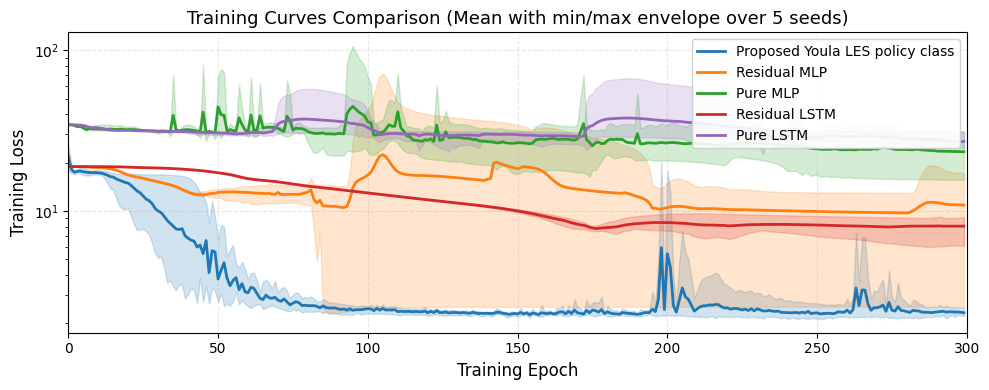


FINAL TRAINING LOSSES (Mean with min/max range over seeds)
Augmented Controller:  2.330037 (min: 2.226245, max: 2.506682)
Residual MLP:          10.888950 (min: 2.535913, max: 17.109386)
Pure MLP:              23.421860 (min: 15.672612, max: 31.153603)
Residual LSTM:         8.059515 (min: 6.107935, max: 9.107302)
Pure LSTM:             27.205455 (min: 24.777340, max: 31.349911)


In [3]:
# ============================================================
# PLOT TRAINING CURVES WITH CONFIDENCE REGIONS
# Shows mean with min/max envelope across all seeds
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import pickle

# ============================================================
# EMERGENCY SAVE: Save all training curves to disk
# ============================================================
training_curves_data = {
    'aug_loss_history_all_seeds': aug_loss_history_all_seeds,
    'residual_mlp_loss_history_all_seeds': residual_mlp_loss_history_all_seeds,
    'pure_mlp_loss_history_all_seeds': pure_mlp_loss_history_all_seeds,
    'residual_lstm_loss_history_all_seeds': residual_lstm_loss_history_all_seeds,
    'pure_lstm_loss_history_all_seeds': pure_lstm_loss_history_all_seeds,
    'seeds': SEEDS
}

curves_path = os.path.join(MODELS_DIR, 'training_curves_all_seeds.pkl')
with open(curves_path, 'wb') as f:
    pickle.dump(training_curves_data, f)
print(f"✓ SAVED TRAINING CURVES: {curves_path}")
print("  (All loss histories backed up to disk)\n")

def prepare_curve_data_minmax(loss_dict_all_seeds):
    """Use min/max envelope instead of mean ± std"""
    min_len = min(len(loss_dict_all_seeds[seed]) for seed in SEEDS)
    curves = [loss_dict_all_seeds[seed][:min_len] for seed in SEEDS]
    curves = np.array(curves)
    mean_curve = np.mean(curves, axis=0)
    min_curve = np.min(curves, axis=0)
    max_curve = np.max(curves, axis=0)
    return mean_curve, min_curve, max_curve

# Prepare all curves with min/max
aug_mean, aug_min, aug_max = prepare_curve_data_minmax(aug_loss_history_all_seeds)
res_mlp_mean, res_mlp_min, res_mlp_max = prepare_curve_data_minmax(residual_mlp_loss_history_all_seeds)
pure_mlp_mean, pure_mlp_min, pure_mlp_max = prepare_curve_data_minmax(pure_mlp_loss_history_all_seeds)
res_lstm_mean, res_lstm_min, res_lstm_max = prepare_curve_data_minmax(residual_lstm_loss_history_all_seeds)
pure_lstm_mean, pure_lstm_min, pure_lstm_max = prepare_curve_data_minmax(pure_lstm_loss_history_all_seeds)

# Create epochs arrays
epochs_aug = np.arange(len(aug_mean))
epochs_res_mlp = np.arange(len(res_mlp_mean))
epochs_pure_mlp = np.arange(len(pure_mlp_mean))
epochs_res_lstm = np.arange(len(res_lstm_mean))
epochs_pure_lstm = np.arange(len(pure_lstm_mean))

# Create figure
fig, ax = plt.subplots(figsize=(10, 4))

# Define colors
colors = {
    'aug': '#1f77b4',
    'res_mlp': '#ff7f0e',
    'pure_mlp': '#2ca02c',
    'res_lstm': '#d62728',
    'pure_lstm': '#9467bd'
}

# Plot all with min/max envelope
ax.plot(epochs_aug, aug_mean, color=colors['aug'], linewidth=2, label='Proposed Youla LES policy class')
ax.fill_between(epochs_aug, aug_min, aug_max, color=colors['aug'], alpha=0.2)

ax.plot(epochs_res_mlp, res_mlp_mean, color=colors['res_mlp'], linewidth=2, label='Residual MLP')
ax.fill_between(epochs_res_mlp, res_mlp_min, res_mlp_max, color=colors['res_mlp'], alpha=0.2)

ax.plot(epochs_pure_mlp, pure_mlp_mean, color=colors['pure_mlp'], linewidth=2, label='Pure MLP')
ax.fill_between(epochs_pure_mlp, pure_mlp_min, pure_mlp_max, color=colors['pure_mlp'], alpha=0.2)

ax.plot(epochs_res_lstm, res_lstm_mean, color=colors['res_lstm'], linewidth=2, label='Residual LSTM')
ax.fill_between(epochs_res_lstm, res_lstm_min, res_lstm_max, color=colors['res_lstm'], alpha=0.2)

ax.plot(epochs_pure_lstm, pure_lstm_mean, color=colors['pure_lstm'], linewidth=2, label='Pure LSTM')
ax.fill_between(epochs_pure_lstm, pure_lstm_min, pure_lstm_max, color=colors['pure_lstm'], alpha=0.2)

# Formatting
ax.set_xlabel('Training Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title(f'Training Curves Comparison (Mean with min/max envelope over {NUM_SEEDS} seeds)', fontsize=13)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([0, max(len(epochs_aug), len(epochs_res_mlp), len(epochs_pure_mlp),
                     len(epochs_res_lstm), len(epochs_pure_lstm))])
ax.set_yscale('log')

plt.tight_layout()

# Save figure
fig_path = os.path.join(FIGURES_DIR, 'training_curves_comparison_confidence.pdf')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {fig_path}")

plt.show()

# Print statistics
print("\n" + "="*60)
print("FINAL TRAINING LOSSES (Mean with min/max range over seeds)")
print("="*60)
print(f"Augmented Controller:  {aug_mean[-1]:.6f} (min: {aug_min[-1]:.6f}, max: {aug_max[-1]:.6f})")
print(f"Residual MLP:          {res_mlp_mean[-1]:.6f} (min: {res_mlp_min[-1]:.6f}, max: {res_mlp_max[-1]:.6f})")
print(f"Pure MLP:              {pure_mlp_mean[-1]:.6f} (min: {pure_mlp_min[-1]:.6f}, max: {pure_mlp_max[-1]:.6f})")
print(f"Residual LSTM:         {res_lstm_mean[-1]:.6f} (min: {res_lstm_min[-1]:.6f}, max: {res_lstm_max[-1]:.6f})")
print(f"Pure LSTM:             {pure_lstm_mean[-1]:.6f} (min: {pure_lstm_min[-1]:.6f}, max: {pure_lstm_max[-1]:.6f})")
print("="*60)


In [5]:
# ============================================================
# RE-DEFINE f AND g FUNCTIONS FOR EVALUATION
# ============================================================
# This cell MUST be run after loading the trained models and BEFORE evaluation
# to ensure f and g are properly defined and match training behavior exactly.
# This fixes the issue where f and g were overwritten by file handles.

print("=" * 60)
print("RE-DEFINING f AND g FUNCTIONS")
print("=" * 60)

# Extract params from the trained augmented system to ensure consistency
#params = aug_system_train.params

# Define drift dynamics f(x, params)
# def f(x, params):
#     """
#     Drift dynamics: f(x)
#     x = [x_cart, x_dot_cart, theta, theta_dot]

#     This function MUST match exactly what was used during training.
#     """
#     M, m, L, g, b = params['M'], params['m'], params['L'], params['g'], params['b']

#     x_pos = x[..., 0]
#     x_dot = x[..., 1]
#     theta = x[..., 2]
#     theta_dot = x[..., 3]

#     sin_theta = torch.sin(theta)
#     cos_theta = torch.cos(theta)

#     # Denominator for dynamics
#     denom = M + m * sin_theta**2

#     # Cart acceleration (without control input)
#     x_ddot = (m * L * theta_dot**2 * sin_theta - b * x_dot - m * g * sin_theta * cos_theta) / denom

#     # Pendulum angular acceleration (without control input)
#     theta_ddot = (-(m * L * theta_dot**2 * sin_theta * cos_theta) +
#                   b * x_dot * cos_theta +
#                   (M + m) * g * sin_theta) / (L * denom)

#     return torch.stack([x_dot, x_ddot, theta_dot, theta_ddot], dim=-1)

# # Define control influence g(x, params)
# def g(x, params):
#     """
#     Control influence: g(x)
#     Returns the matrix that multiplies the control input u

#     This function MUST match exactly what was used during training.
#     """
#     M, m, L = params['M'], params['m'], params['L']

#     theta = x[..., 2]
#     sin_theta = torch.sin(theta)
#     cos_theta = torch.cos(theta)

#     denom = M + m * sin_theta**2

#     # Control influence on cart acceleration
#     g_x_ddot = 1.0 / denom

#     # Control influence on pendulum angular acceleration
#     g_theta_ddot = -cos_theta / (L * denom)

#     # g(x) returns [0, g_x_ddot, 0, g_theta_ddot]
#     zeros = torch.zeros_like(g_x_ddot)
#     return torch.stack([zeros, g_x_ddot, zeros, g_theta_ddot], dim=-1)

def f(x, params):
    """
    Drift dynamics: f(x)
    x = [x_cart, x_dot_cart, theta, theta_dot]
    """
    M, m, L, g, b = params['M'], params['m'], params['L'], params['g'], params['b']

    x_pos = x[..., 0]
    x_dot = x[..., 1]
    theta = x[..., 2]
    theta_dot = x[..., 3]

    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)

    # Denominator for dynamics
    denom = M + m * sin_theta**2

    # Cart acceleration (without control input)
    x_ddot = (m * L * theta_dot**2 * sin_theta - b * x_dot - m * g * sin_theta * cos_theta) / denom

    # Pendulum angular acceleration (without control input)
    theta_ddot = (-(m * L * theta_dot**2 * sin_theta * cos_theta) +
                  b * x_dot * cos_theta +
                  (M + m) * g * sin_theta) / (L * denom)

    return torch.stack([x_dot, x_ddot, theta_dot, theta_ddot], dim=-1)

def g(x, params):
    """
    Control influence: g(x)
    Returns the matrix that multiplies the control input u
    """
    M, m, L = params['M'], params['m'], params['L']

    theta = x[..., 2]
    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)

    denom = M + m * sin_theta**2

    # Control influence on cart acceleration
    g_x_ddot = 1.0 / denom

    # Control influence on pendulum angular acceleration
    g_theta_ddot = -cos_theta / (L * denom)

    # g(x) returns [0, g_x_ddot, 0, g_theta_ddot]
    zeros = torch.zeros_like(g_x_ddot)
    return torch.stack([zeros, g_x_ddot, zeros, g_theta_ddot], dim=-1)



print("\n✓ Functions f and g have been re-defined")

# ============================================================
# VERIFICATION: Test that f and g work correctly
# ============================================================
print("\n" + "=" * 60)
print("VERIFYING f AND g FUNCTIONS")
print("=" * 60)

# Test with a sample state
x_test = torch.tensor([[0.0, 0.0, 0.1, 0.0]], device=device)  # Small perturbation
print(f"\nTest state x: {x_test.cpu().numpy()}")

# Compute f(x)
f_test = f(x_test, params)
print(f"f(x): {f_test.cpu().numpy()}")

# Compute g(x)
g_test = g(x_test, params)
print(f"g(x): {g_test.cpu().numpy()}")

# Verify by checking that f and g produce reasonable values
print("\nSanity checks:")
print(f"  f[0] should equal x[1] (velocity): {f_test[0, 0].item():.6f} == {x_test[0, 1].item():.6f} ✓" if abs(f_test[0, 0] - x_test[0, 1]) < 1e-6 else f"  ERROR in f[0]")
print(f"  f[2] should equal x[3] (ang velocity): {f_test[0, 2].item():.6f} == {x_test[0, 3].item():.6f} ✓" if abs(f_test[0, 2] - x_test[0, 3]) < 1e-6 else f"  ERROR in f[2]")
print(f"  g[0] should be 0: {g_test[0, 0].item():.6f} ✓" if abs(g_test[0, 0]) < 1e-6 else f"  ERROR in g[0]")
print(f"  g[2] should be 0: {g_test[0, 2].item():.6f} ✓" if abs(g_test[0, 2]) < 1e-6 else f"  ERROR in g[2]")
print(f"  g[1] should be positive: {g_test[0, 1].item():.6f} > 0 ✓" if g_test[0, 1] > 0 else f"  ERROR in g[1]")

# More rigorous verification: extract f and g from augmented system's forward pass
print("\n" + "=" * 60)
print("COMPARING f AND g WITH AUGMENTED SYSTEM COMPUTATION")
print("=" * 60)

with torch.no_grad():
    xi_test, q_test = aug_system_train.compute_initial_conditions(x_test)
    aug_state_test = torch.cat([x_test, xi_test, q_test], dim=-1)

    # Manually extract what the augmented system computes for f(x) and g(x)
    # by looking at its forward method code
    x_aug = aug_state_test[..., :4]
    xi_aug = aug_state_test[..., 4:8]
    q_aug = aug_state_test[..., 8:]

    # The augmented system computes: f_x = f(x, self.params) and g_x = g(x, self.params)
    # We can't extract these directly, but we can verify consistency differently

    # Instead, let's verify that when we use the SAME control, we get the same x_dot
    u_test = -torch.matmul(x_test, K_torch.T).squeeze(-1)

    # Our f and g
    f_our = f(x_test, params)
    g_our = g(x_test, params)
    x_dot_our = f_our + g_our * u_test.unsqueeze(-1)

    print(f"Test control u = -Kx: {u_test.cpu().numpy()}")
    print(f"Our f(x):       {f_our.cpu().numpy()}")
    print(f"Our g(x):       {g_our.cpu().numpy()}")
    print(f"Our x_dot:      {x_dot_our.cpu().numpy()}")

# Test with equilibrium point (should give zero)
print("\n" + "=" * 60)
print("TESTING AT EQUILIBRIUM (x=0)")
print("=" * 60)

x_eq = torch.zeros(1, 4, device=device)
f_eq = f(x_eq, params)
g_eq = g(x_eq, params)

print(f"f(0): {f_eq.cpu().numpy()}")
print(f"g(0): {g_eq.cpu().numpy()}")
print(f"Expected g(0): [0, 1, 0, -2] (approximately)")

if torch.allclose(f_eq, torch.zeros_like(f_eq), atol=1e-6):
    print("✓ f(0) = 0 (correct for equilibrium)")
else:
    print("✗ WARNING: f(0) should be zero at equilibrium!")

print("\n" + "=" * 60)
print("✓ f AND g FUNCTIONS ARE CORRECTLY DEFINED")
print("✓ Ready to evaluate all controllers with consistent dynamics")
print("=" * 60)
print("\nNote: Different controllers will produce different trajectories")
print("because they use different control laws u(x), but all use the same f and g.\n")

RE-DEFINING f AND g FUNCTIONS

✓ Functions f and g have been re-defined

VERIFYING f AND g FUNCTIONS

Test state x: [[0.  0.  0.1 0. ]]
f(x): [[ 0.         -0.29147044  0.          2.5387602 ]]
g(x): [[ 0.          0.99701893  0.         -1.9840759 ]]

Sanity checks:
  f[0] should equal x[1] (velocity): 0.000000 == 0.000000 ✓
  f[2] should equal x[3] (ang velocity): 0.000000 == 0.000000 ✓
  g[0] should be 0: 0.000000 ✓
  g[2] should be 0: 0.000000 ✓
  g[1] should be positive: 0.997019 > 0 ✓

COMPARING f AND g WITH AUGMENTED SYSTEM COMPUTATION
Test control u = -Kx: [7.4950967]
Our f(x):       [[ 0.         -0.29147044  0.          2.5387602 ]]
Our g(x):       [[ 0.          0.99701893  0.         -1.9840759 ]]
Our x_dot:      [[  0.         7.181283   0.       -12.332081]]

TESTING AT EQUILIBRIUM (x=0)
f(0): [[0. 0. 0. 0.]]
g(0): [[ 0.  1.  0. -2.]]
Expected g(0): [0, 1, 0, -2] (approximately)
✓ f(0) = 0 (correct for equilibrium)

✓ f AND g FUNCTIONS ARE CORRECTLY DEFINED
✓ Ready to eva

## Evaluation: Five-Way Comparison with Confidence Regions

Evaluate all five trained controllers with multiple simulations to compute confidence regions.

In [6]:
# ============================================================
# SIX-WAY EVALUATION WITH CONFIDENCE REGIONS
# Run 5 simulations for each controller from same initial conditions
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

print("="*60)
print("SIX-WAY EVALUATION")
print("="*60)

# Evaluation parameters
N_EVAL_SIMS = 5
T_EVAL = 5.0
N_EVAL_STEPS = 200
t_eval = torch.linspace(0.0, T_EVAL, N_EVAL_STEPS, device=device)

# Generate N_EVAL_SIMS different initial conditions
x0_eval_batch = torch.zeros(N_EVAL_SIMS, STATE_DIM, device=device)
x0_eval_batch[:, 0] = -2.0  # Cart position
# Add small variations
torch.manual_seed(123)  # For reproducibility
x0_eval_batch += 0.05 * torch.randn_like(x0_eval_batch)

print(f"\nRunning {N_EVAL_SIMS} simulations for each controller...")
print(f"Time horizon: {T_EVAL}s")
print(f"Time steps: {N_EVAL_STEPS}")

# ============================================================
# 1. BASE LQR CONTROLLER: u = -Kx
# ============================================================
print("\n1/6: Evaluating Base LQR...")

def closed_loop_base_lqr(t, x):
    u = -torch.matmul(x, K_torch.T).squeeze(-1)
    fx = f(x, params)
    gx = g(x, params)
    return fx + gx * u.unsqueeze(-1)

trajs_base = []
with torch.no_grad():
    for i in range(N_EVAL_SIMS):
        x0_i = x0_eval_batch[i:i+1]
        traj = odeint(closed_loop_base_lqr, x0_i, t_eval, method='rk4')
        trajs_base.append(traj.squeeze(1).cpu().numpy())

trajs_base = np.array(trajs_base)  # Shape: (N_EVAL_SIMS, N_EVAL_STEPS, STATE_DIM)
print(f"   Base LQR trajectories shape: {trajs_base.shape}")

# ============================================================
# 2. AUGMENTED CONTROLLER
# ============================================================
print("\n2/6: Evaluating Augmented Controller...")

aug_system_train.eval()
trajs_aug = []

with torch.no_grad():
    for i in range(N_EVAL_SIMS):
        x0_i = x0_eval_batch[i:i+1]
        xi0_i, q0_i = aug_system_train.compute_initial_conditions(x0_i)
        aug_state0_i = torch.cat([x0_i, xi0_i, q0_i], dim=-1)



        traj_aug = odeint(aug_system_train, aug_state0_i, t_eval, method='rk4')
        x_traj = traj_aug[:, :, :STATE_DIM].squeeze(1).cpu().numpy()
        trajs_aug.append(x_traj)

trajs_aug = np.array(trajs_aug)
print(f"   Augmented trajectories shape: {trajs_aug.shape}")

# ============================================================
# 3. RESIDUAL MLP: u = -Kx + MLP(x)
# ============================================================
print("\n3/6: Evaluating Residual MLP...")

def closed_loop_residual_mlp(t, x):
    u_lqr = -torch.matmul(x, K_torch.T).squeeze(-1)
    u_mlp = mlp_residual(x).squeeze(-1)
    u = u_lqr + u_mlp
    fx = f(x, params)
    gx = g(x, params)
    return fx + gx * u.unsqueeze(-1)

mlp_residual.eval()
trajs_mlp_res = []

with torch.no_grad():
    for i in range(N_EVAL_SIMS):
        x0_i = x0_eval_batch[i:i+1]
        traj = odeint(closed_loop_residual_mlp, x0_i, t_eval, method='rk4')
        trajs_mlp_res.append(traj.squeeze(1).cpu().numpy())

trajs_mlp_res = np.array(trajs_mlp_res)
print(f"   Residual MLP trajectories shape: {trajs_mlp_res.shape}")

# ============================================================
# 4. PURE MLP: u = MLP(x)
# ============================================================
print("\n4/6: Evaluating Pure MLP...")

def closed_loop_pure_mlp(t, x):
    u = mlp_pure(x).squeeze(-1)
    fx = f(x, params)
    gx = g(x, params)
    return fx + gx * u.unsqueeze(-1)

mlp_pure.eval()
trajs_mlp_pure = []

with torch.no_grad():
    for i in range(N_EVAL_SIMS):
        x0_i = x0_eval_batch[i:i+1]
        traj = odeint(closed_loop_pure_mlp, x0_i, t_eval, method='rk4')
        trajs_mlp_pure.append(traj.squeeze(1).cpu().numpy())

trajs_mlp_pure = np.array(trajs_mlp_pure)
print(f"   Pure MLP trajectories shape: {trajs_mlp_pure.shape}")

# ============================================================
# 5. RESIDUAL LSTM: u = -Kx + LSTM(x)
# ============================================================
print("\n5/6: Evaluating Residual LSTM...")

def closed_loop_residual_lstm(t, x):
    u_lqr = -torch.matmul(x, K_torch.T).squeeze(-1)
    u_lstm = lstm_residual(x).squeeze(-1)
    u = u_lqr + u_lstm
    fx = f(x, params)
    gx = g(x, params)
    return fx + gx * u.unsqueeze(-1)

lstm_residual.eval()
trajs_lstm_res = []

with torch.no_grad():
    for i in range(N_EVAL_SIMS):
        x0_i = x0_eval_batch[i:i+1]
        traj = odeint(closed_loop_residual_lstm, x0_i, t_eval, method='rk4')
        trajs_lstm_res.append(traj.squeeze(1).cpu().numpy())

trajs_lstm_res = np.array(trajs_lstm_res)
print(f"   Residual LSTM trajectories shape: {trajs_lstm_res.shape}")

# ============================================================
# 6. PURE LSTM: u = LSTM(x)
# ============================================================
print("\n6/6: Evaluating Pure LSTM...")

def closed_loop_pure_lstm(t, x):
    u = lstm_pure(x).squeeze(-1)
    fx = f(x, params)
    gx = g(x, params)
    return fx + gx * u.unsqueeze(-1)

lstm_pure.eval()
trajs_lstm_pure = []

with torch.no_grad():
    for i in range(N_EVAL_SIMS):
        x0_i = x0_eval_batch[i:i+1]
        traj = odeint(closed_loop_pure_lstm, x0_i, t_eval, method='rk4')
        trajs_lstm_pure.append(traj.squeeze(1).cpu().numpy())

trajs_lstm_pure = np.array(trajs_lstm_pure)
print(f"   Pure LSTM trajectories shape: {trajs_lstm_pure.shape}")


print("\n" + "="*60)
print("All evaluations complete!")
print("="*60)

# Convert time to numpy
t_eval_np = t_eval.cpu().numpy()


SIX-WAY EVALUATION

Running 5 simulations for each controller...
Time horizon: 5.0s
Time steps: 200

1/6: Evaluating Base LQR...
   Base LQR trajectories shape: (5, 200, 4)

2/6: Evaluating Augmented Controller...
   Augmented trajectories shape: (5, 200, 4)

3/6: Evaluating Residual MLP...
   Residual MLP trajectories shape: (5, 200, 4)

4/6: Evaluating Pure MLP...
   Pure MLP trajectories shape: (5, 200, 4)

5/6: Evaluating Residual LSTM...
   Residual LSTM trajectories shape: (5, 200, 4)

6/6: Evaluating Pure LSTM...
   Pure LSTM trajectories shape: (5, 200, 4)

All evaluations complete!


### State Trajectories with Confidence Regions


Generating state trajectory plots with confidence regions...
✓ Saved: state_trajectories_comparison.pdf
✓ Saved: state_trajectories_comparison.png


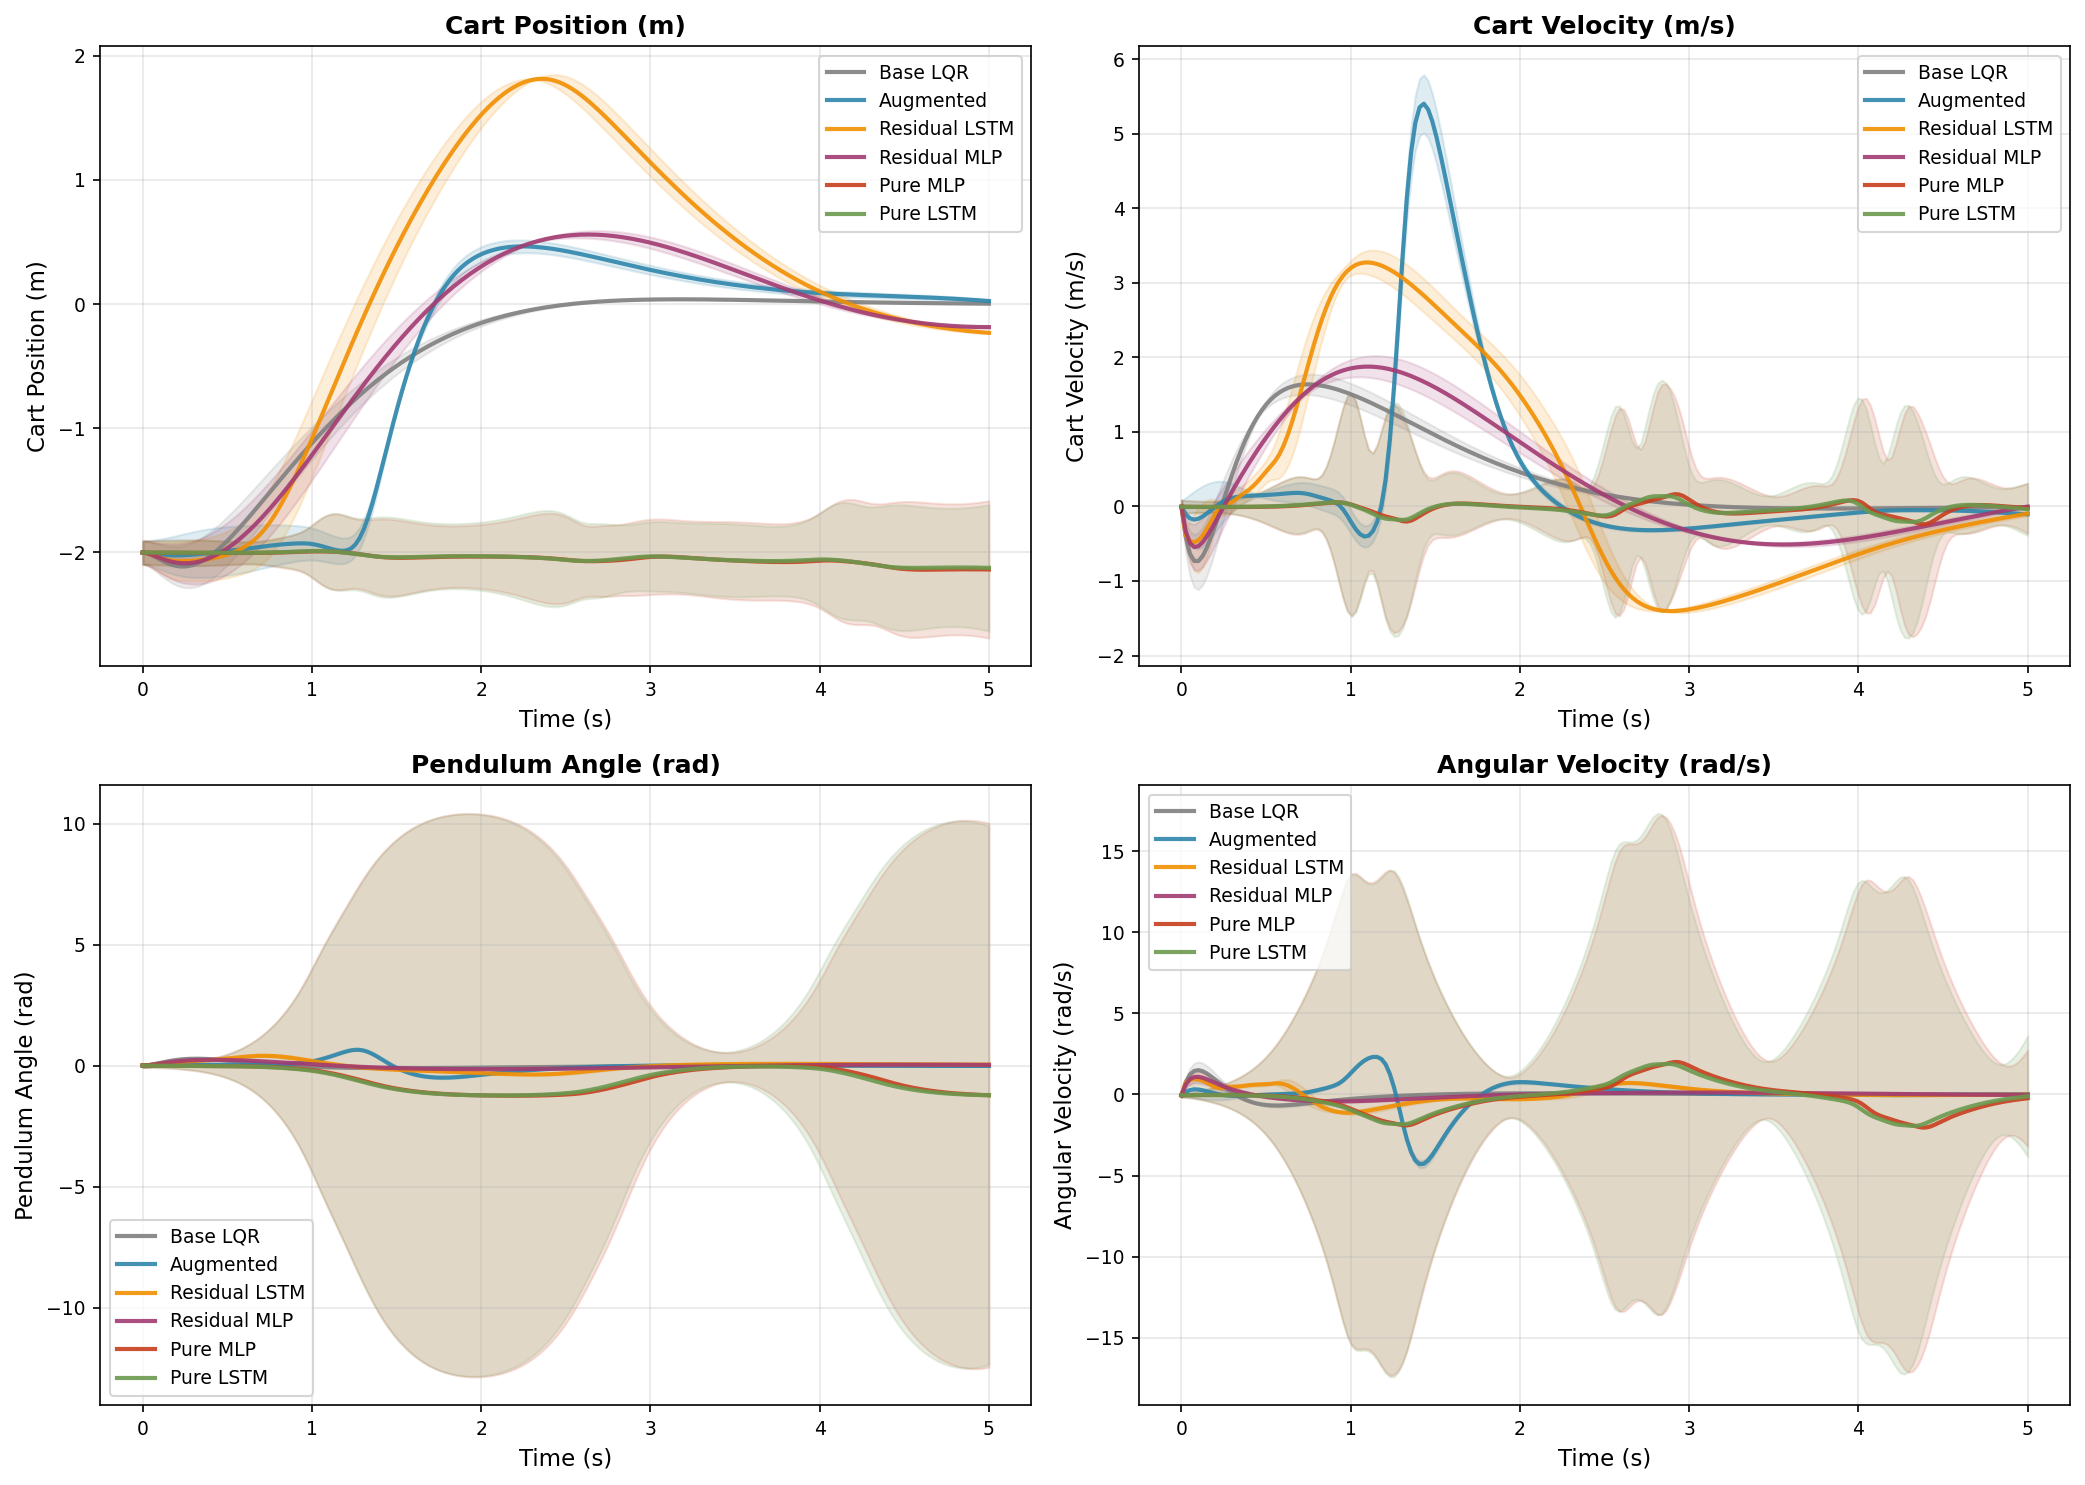

In [7]:
# ============================================================
# PLOT STATE TRAJECTORIES WITH CONFIDENCE REGIONS
# ============================================================
print("\nGenerating state trajectory plots with confidence regions...")

# Set publication style
plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi': 150
})

# State labels
state_labels = ['Cart Position (m)', 'Cart Velocity (m/s)',
                'Pendulum Angle (rad)', 'Angular Velocity (rad/s)']

# Colors for each controller
colors = ['#808080', '#2E86AB', '#F18F01', '#A23B72', '#C73E1D', '#6A994E']
labels = ['Base LQR', 'Augmented', 'Residual LSTM', 'Residual MLP', 'Pure MLP', 'Pure LSTM']
all_trajs = [trajs_base, trajs_aug, trajs_lstm_res, trajs_mlp_res, trajs_mlp_pure, trajs_lstm_pure]

# Create figure with 4 subplots (one for each state)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for state_idx in range(STATE_DIM):
    ax = axes[state_idx]

    for controller_idx, (traj_set, color, label) in enumerate(zip(all_trajs, colors, labels)):
        # traj_set shape: (N_EVAL_SIMS, N_EVAL_STEPS, STATE_DIM)
        # Extract this state across all simulations
        state_data = traj_set[:, :, state_idx]  # (N_EVAL_SIMS, N_EVAL_STEPS)

        # Compute mean and std
        mean_traj = np.mean(state_data, axis=0)
        std_traj = np.std(state_data, axis=0)

        # Plot mean
        ax.plot(t_eval_np, mean_traj, color=color, linewidth=2, label=label, alpha=0.9)

        # Plot 95% confidence region (mean ± 1.96*std)
        ax.fill_between(t_eval_np,
                        mean_traj - 1.96*std_traj,
                        mean_traj + 1.96*std_traj,
                        color=color, alpha=0.15)

    ax.set_xlabel('Time (s)', fontsize=11)
    ax.set_ylabel(state_labels[state_idx], fontsize=11)
    ax.set_title(f'{state_labels[state_idx]}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'state_trajectories_comparison.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(FIGURES_DIR, 'state_trajectories_comparison.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved: state_trajectories_comparison.pdf")
print(f"✓ Saved: state_trajectories_comparison.png")
plt.show()


### Tip Trajectories with Confidence Regions


Generating tip trajectory plots with confidence regions...
✓ Saved: tip_trajectories_comparison_all.pdf
✓ Saved: tip_trajectories_comparison_all.png


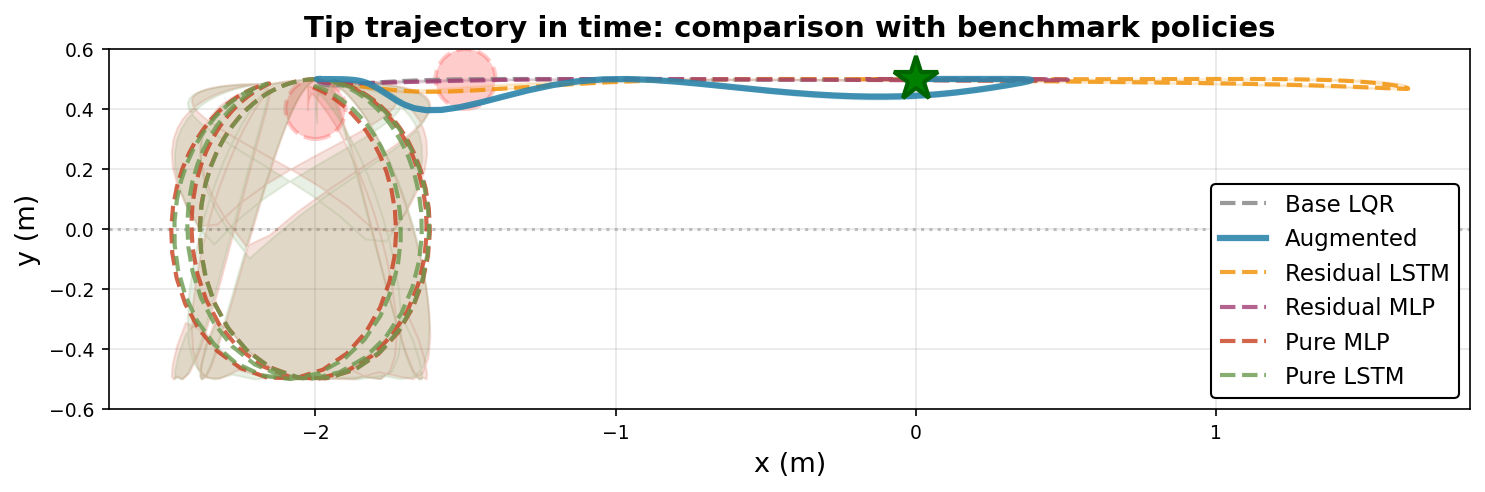

✓ Saved: tip_trajectories_comparison.pdf
✓ Saved: tip_trajectories_comparison.png


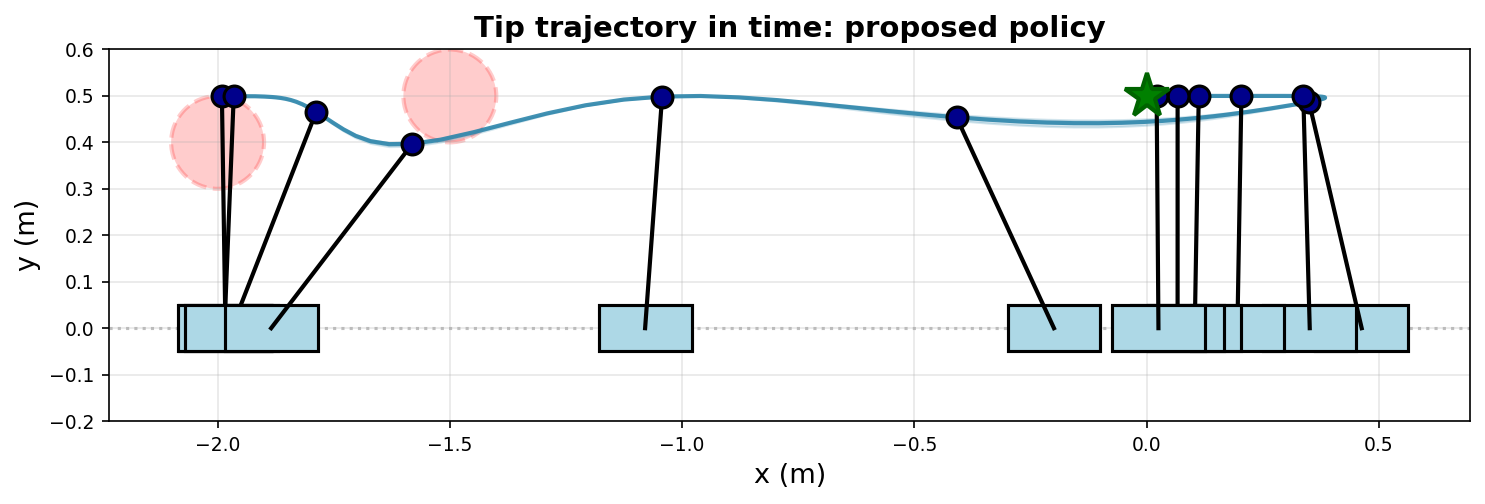

✓ Saved: tip_trajectories_comparison_no_shadows.pdf
✓ Saved: tip_trajectories_comparison_no_shadows.png


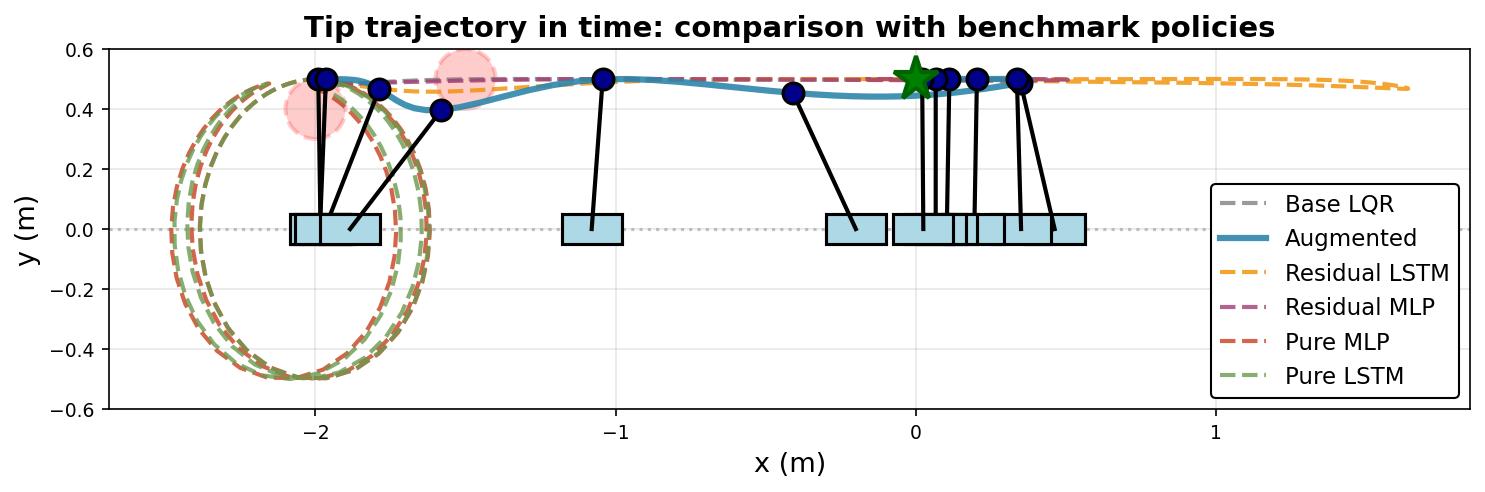

✓ Saved: tip_coordinates_comparison.pdf
✓ Saved: tip_coordinates_comparison.png


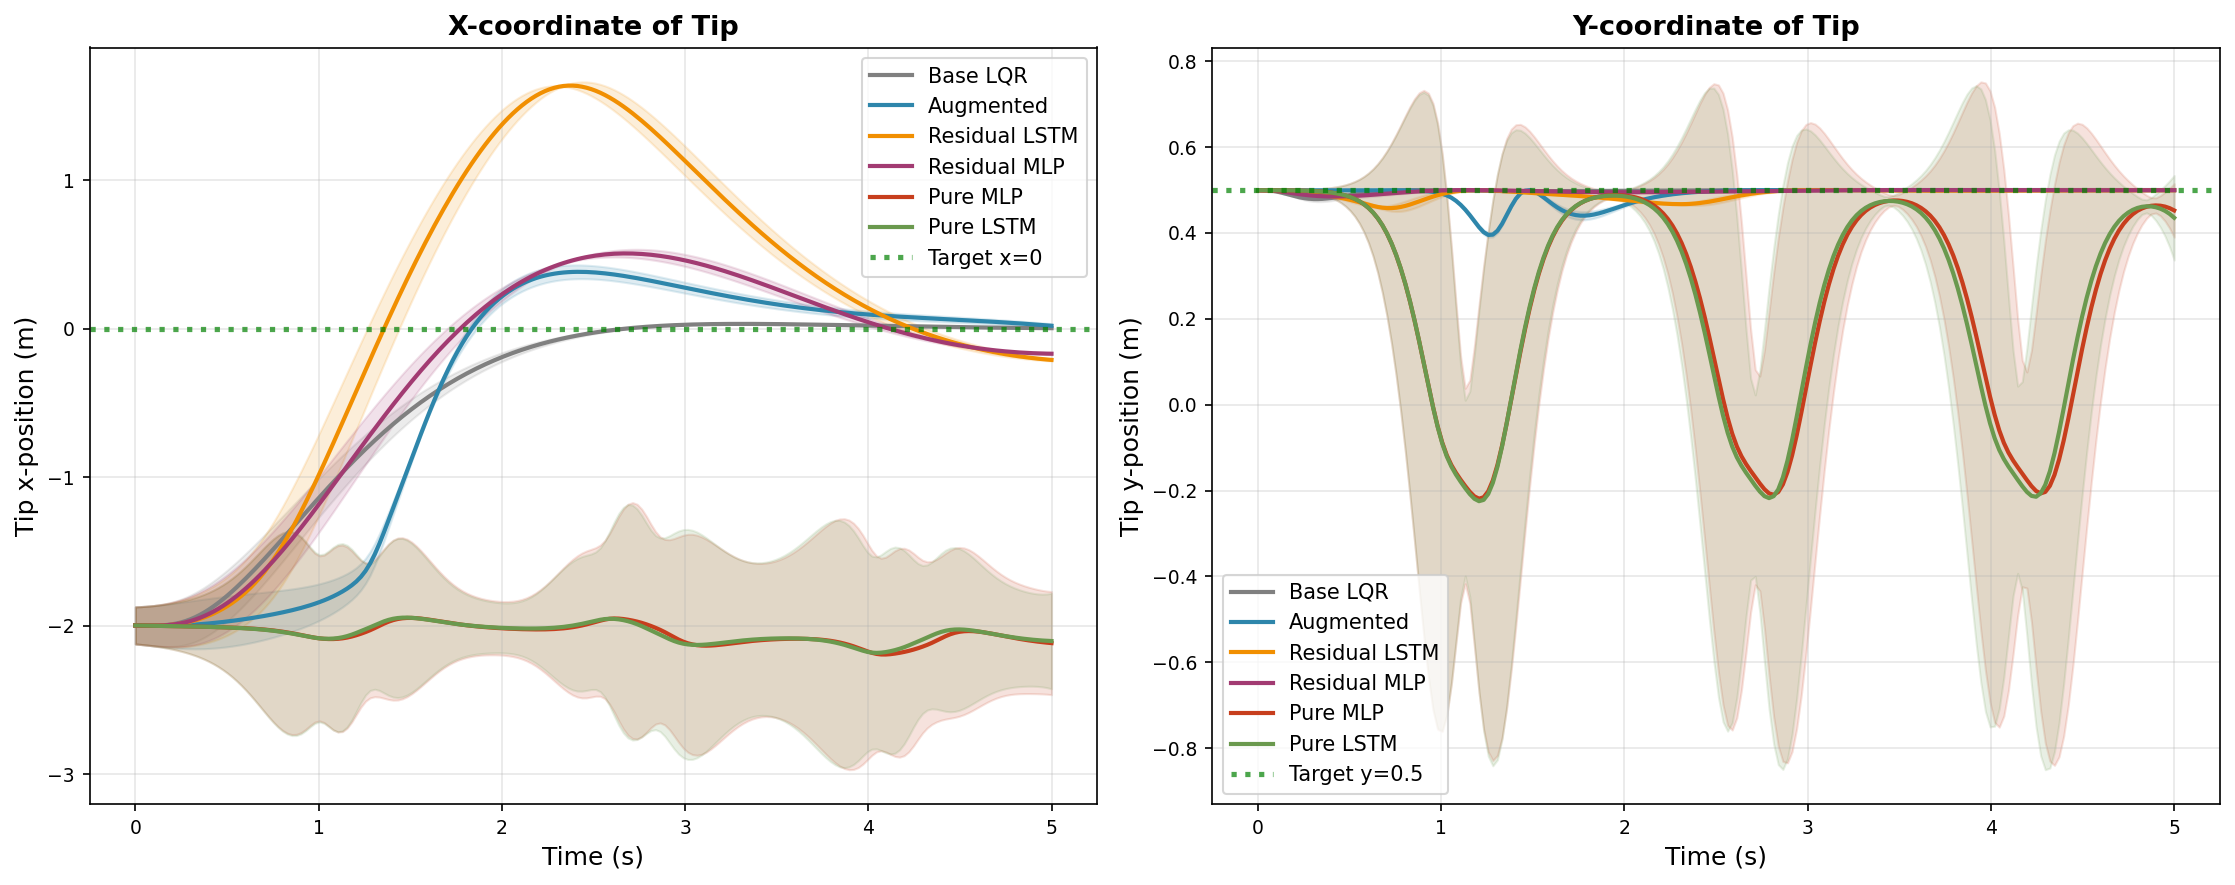

In [8]:
# ============================================================
# PLOT TIP TRAJECTORIES WITH CONFIDENCE REGIONS
# ============================================================
print("\nGenerating tip trajectory plots with confidence regions...")

L_val = params['L']

# Obstacle parameters (fixed)
OBSTACLE_RADIUS = 0.1
OBSTACLE_CENTER = -1.5
OBSTACLE_CENTER2 = -2
OBSTACLE_CENTER2_y = 0.4
OBSTACLE_DSAFE  = 0.05  # dsafe from the problem statement

# Compute tip positions for all controllers and simulations
def compute_tip_trajectories(traj_set):
    """
    traj_set: (N_EVAL_SIMS, N_EVAL_STEPS, STATE_DIM)
    Returns: x_tip (N_EVAL_SIMS, N_EVAL_STEPS), y_tip (N_EVAL_SIMS, N_EVAL_STEPS)
    """
    x_cart = traj_set[:, :, 0]  # (N_EVAL_SIMS, N_EVAL_STEPS)
    theta = traj_set[:, :, 2]

    x_tip = x_cart + L_val * np.sin(theta)
    y_tip = L_val * np.cos(theta)

    return x_tip, y_tip

# Compute for all controllers
tip_data = []
for traj_set in all_trajs:
    x_tip, y_tip = compute_tip_trajectories(traj_set)
    tip_data.append((x_tip, y_tip))

# ============================================================
# PLOT 1: All controllers comparison (no cart-pendulum)
# ============================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Draw rail at y=0 (more subtle)
ax.axhline(y=0, color='gray', linestyle=':', linewidth=1.5, alpha=0.5, zorder=1)

# Draw obstacles (no label)
obstacle_circle1 = Circle((OBSTACLE_CENTER, L_val), radius=OBSTACLE_RADIUS,
                         fill=True, facecolor='red', alpha=0.2,
                         edgecolor='red', linestyle='--', linewidth=2)
ax.add_patch(obstacle_circle1)

obstacle_circle2 = Circle((OBSTACLE_CENTER2, OBSTACLE_CENTER2_y), radius=OBSTACLE_RADIUS,
                         fill=True, facecolor='red', alpha=0.2,
                         edgecolor='red', linestyle='--', linewidth=2)
ax.add_patch(obstacle_circle2)

# Target (no label)
ax.plot(0.0, L_val, marker='*', markersize=22, color='green',
        markeredgewidth=2, markeredgecolor='darkgreen', zorder=10)

# Plot each controller's trajectory with confidence region
for idx, ((x_tip, y_tip), color, label) in enumerate(zip(tip_data, colors, labels)):
    sim_idx = 0

    # Compute min/max y for confidence region across all simulations
    y_min = np.min(y_tip, axis=0)
    y_max = np.max(y_tip, axis=0)

    # Get trajectory for selected simulation
    x_traj = x_tip[sim_idx]
    y_traj = y_tip[sim_idx]

    # Plot confidence region (min/max envelope)
    ax.fill_between(x_traj, y_min, y_max, color=color, alpha=0.15, zorder=2)

    # Plot the trajectory
    if idx == 1:  # Augmented controller
        ax.plot(x_traj, y_traj, color=color, linewidth=3, label=label, alpha=0.9, zorder=5)
    else:
        ax.plot(x_traj, y_traj, color=color, linewidth=2, linestyle='--',
               label=label, alpha=0.8, zorder=4)

ax.set_xlabel('x (m)', fontsize=13)
ax.set_ylabel('y (m)', fontsize=13)
ax.set_title('Tip trajectory in time: comparison with benchmark policies', fontsize=14, fontweight='bold')
ax.set_ylim(-0.6, 0.6)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')
ax.legend(fontsize=11, loc='best', framealpha=1.0, edgecolor='black')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'tip_trajectories_comparison_all.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(FIGURES_DIR, 'tip_trajectories_comparison_all.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved: tip_trajectories_comparison_all.pdf")
print(f"✓ Saved: tip_trajectories_comparison_all.png")
plt.show()

# ============================================================
# PLOT 2: Augmented controller only with cart-pendulum visualization
# ============================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Draw rail at y=0 (more subtle)
ax.axhline(y=0, color='gray', linestyle=':', linewidth=1.5, alpha=0.5, zorder=1)

# Draw obstacles (no label)
obstacle_circle1 = Circle((OBSTACLE_CENTER, L_val), radius=OBSTACLE_RADIUS,
                         fill=True, facecolor='red', alpha=0.2,
                         edgecolor='red', linestyle='--', linewidth=2)
ax.add_patch(obstacle_circle1)

obstacle_circle2 = Circle((OBSTACLE_CENTER2, OBSTACLE_CENTER2_y), radius=OBSTACLE_RADIUS,
                         fill=True, facecolor='red', alpha=0.2,
                         edgecolor='red', linestyle='--', linewidth=2)
ax.add_patch(obstacle_circle2)

# Target (no label)
ax.plot(0.0, L_val, marker='*', markersize=22, color='green',
        markeredgewidth=2, markeredgecolor='darkgreen', zorder=10)

# Choose times to display cart-pendulum (10 equally spaced frames)
# Tunable: modify these indices to change display times
display_time_indices = [int(i * (len(t_eval_np)-1) / 9) for i in range(10)]
i3 = display_time_indices[2]
i4 = display_time_indices[3]

extra1 = int(i3 + (i4 - i3) * 1/3)
extra2 = int(i3 + (i4 - i3) * 2/3)

display_time_indices = (
    display_time_indices[:3] +
    [extra1, extra2] +
    display_time_indices[3:]
)

# Plot Augmented controller only (idx=1)
idx = 1
x_tip, y_tip = tip_data[idx]
color = colors[idx]
label = labels[idx]
sim_idx = 0

# Compute min/max y for confidence region across all simulations
y_min = np.min(y_tip, axis=0)
y_max = np.max(y_tip, axis=0)

# Get trajectory for selected simulation
x_traj = x_tip[sim_idx]
y_traj = y_tip[sim_idx]

# Plot confidence region (min/max envelope)
ax.fill_between(x_traj, y_min, y_max, color=color, alpha=0.2, zorder=2)

# Plot the trajectory
ax.plot(x_traj, y_traj, color=color, linewidth=2, alpha=0.9, zorder=5)

# Draw cart-pendulum at specified times
cart_width = 0.2
cart_height = 0.1

for time_idx in display_time_indices:
    x_cart_pos = all_trajs[idx][sim_idx, time_idx, 0]
    theta_pos = all_trajs[idx][sim_idx, time_idx, 2]

    # Cart position
    cart_x = x_cart_pos
    cart_y = 0  # Cart moves on ground

    # Tip position
    tip_x = x_traj[time_idx]
    tip_y = y_traj[time_idx]

    # Draw cart as rectangle
    cart_rect = plt.Rectangle((cart_x - cart_width/2, cart_y - cart_height/2),
                             cart_width, cart_height,
                             facecolor='lightblue', edgecolor='black',
                             linewidth=1.5, zorder=6)
    ax.add_patch(cart_rect)

    # Draw pendulum rod
    ax.plot([cart_x, tip_x], [cart_y, tip_y], 'k-', linewidth=2, zorder=6)

    # Draw pendulum bob (larger and heavier looking)
    ax.plot(tip_x, tip_y, 'o', markersize=10, color='darkblue',
           markeredgecolor='black', markeredgewidth=1.5, zorder=7)

ax.set_xlabel('x (m)', fontsize=13)
ax.set_ylabel('y (m)', fontsize=13)
ax.set_title('Tip trajectory in time: proposed policy', fontsize=14, fontweight='bold')
ax.set_ylim(-0.2, 0.6)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'tip_trajectories_comparison.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(FIGURES_DIR, 'tip_trajectories_comparison.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved: tip_trajectories_comparison.pdf")
print(f"✓ Saved: tip_trajectories_comparison.png")
plt.show()

# ============================================================
# PLOT 3: All controllers with cart-pendulum visualization (no shadows)
# ============================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Draw rail at y=0 (more subtle)
ax.axhline(y=0, color='gray', linestyle=':', linewidth=1.5, alpha=0.5, zorder=1)

# Draw obstacles (no label)
obstacle_circle1 = Circle((OBSTACLE_CENTER, L_val), radius=OBSTACLE_RADIUS,
                         fill=True, facecolor='red', alpha=0.2,
                         edgecolor='red', linestyle='--', linewidth=2)
ax.add_patch(obstacle_circle1)

obstacle_circle2 = Circle((OBSTACLE_CENTER2, OBSTACLE_CENTER2_y), radius=OBSTACLE_RADIUS,
                         fill=True, facecolor='red', alpha=0.2,
                         edgecolor='red', linestyle='--', linewidth=2)
ax.add_patch(obstacle_circle2)

# Target (no label)
ax.plot(0.0, L_val, marker='*', markersize=22, color='green',
        markeredgewidth=2, markeredgecolor='darkgreen', zorder=10)

# Plot each controller's trajectory (no confidence region) and cart-pendulum
sim_idx = 0
cart_width = 0.2
cart_height = 0.1

for idx, ((x_tip, y_tip), color, label) in enumerate(zip(tip_data, colors, labels)):
    # Get trajectory for selected simulation
    x_traj = x_tip[sim_idx]
    y_traj = y_tip[sim_idx]

    # Plot the trajectory (no confidence region)
    if idx == 1:  # Augmented controller
        ax.plot(x_traj, y_traj, color=color, linewidth=3, label=label, alpha=0.9, zorder=5)
    else:
        ax.plot(x_traj, y_traj, color=color, linewidth=2, linestyle='--',
               label=label, alpha=0.8, zorder=4)

    # Draw cart-pendulum at specified times (only for augmented to avoid clutter)
    if idx == 1:  # Only draw cart-pendulum for Augmented controller
        for time_idx in display_time_indices:
            x_cart_pos = all_trajs[idx][sim_idx, time_idx, 0]
            theta_pos = all_trajs[idx][sim_idx, time_idx, 2]

            # Cart position
            cart_x = x_cart_pos
            cart_y = 0  # Cart moves on ground

            # Tip position
            tip_x = x_traj[time_idx]
            tip_y = y_traj[time_idx]

            # Draw cart as rectangle
            cart_rect = plt.Rectangle((cart_x - cart_width/2, cart_y - cart_height/2),
                                     cart_width, cart_height,
                                     facecolor='lightblue', edgecolor='black',
                                     linewidth=1.5, zorder=6)
            ax.add_patch(cart_rect)

            # Draw pendulum rod
            ax.plot([cart_x, tip_x], [cart_y, tip_y], 'k-', linewidth=2, zorder=6)

            # Draw pendulum bob
            ax.plot(tip_x, tip_y, 'o', markersize=10, color='darkblue',
                   markeredgecolor='black', markeredgewidth=1.5, zorder=7)

ax.set_xlabel('x (m)', fontsize=13)
ax.set_ylabel('y (m)', fontsize=13)
ax.set_title('Tip trajectory in time: comparison with benchmark policies', fontsize=14, fontweight='bold')
ax.set_ylim(-0.6, 0.6)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')
ax.legend(fontsize=11, loc='best', framealpha=1.0, edgecolor='black')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'tip_trajectories_comparison_no_shadows.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(FIGURES_DIR, 'tip_trajectories_comparison_no_shadows.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved: tip_trajectories_comparison_no_shadows.pdf")
print(f"✓ Saved: tip_trajectories_comparison_no_shadows.png")
plt.show()

# ============================================================
# PLOT 4: Tip x and y coordinates over time with confidence regions
# ============================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# X-coordinate
for (x_tip, y_tip), color, label in zip(tip_data, colors, labels):
    x_mean = np.mean(x_tip, axis=0)
    x_std = np.std(x_tip, axis=0)

    ax1.plot(t_eval_np, x_mean, color=color, linewidth=2, label=label)
    ax1.fill_between(t_eval_np, x_mean - 1.96*x_std, x_mean + 1.96*x_std,
                     color=color, alpha=0.15)

ax1.axhline(y=0, color='green', linestyle=':', linewidth=2.5, alpha=0.7, label='Target x=0')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Tip x-position (m)', fontsize=12)
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_title('X-coordinate of Tip', fontsize=13, fontweight='bold')

# Y-coordinate
for (x_tip, y_tip), color, label in zip(tip_data, colors, labels):
    y_mean = np.mean(y_tip, axis=0)
    y_std = np.std(y_tip, axis=0)

    ax2.plot(t_eval_np, y_mean, color=color, linewidth=2, label=label)
    ax2.fill_between(t_eval_np, y_mean - 1.96*y_std, y_mean + 1.96*y_std,
                     color=color, alpha=0.15)

ax2.axhline(y=L_val, color='green', linestyle=':', linewidth=2.5, alpha=0.7,
            label=f'Target y={L_val}')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Tip y-position (m)', fontsize=12)
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)
ax2.set_title('Y-coordinate of Tip', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'tip_coordinates_comparison.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(FIGURES_DIR, 'tip_coordinates_comparison.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved: tip_coordinates_comparison.pdf")
print(f"✓ Saved: tip_coordinates_comparison.png")
plt.show()

### Animation (Augmented Controller Only)

In [ ]:
# ============================================================
# ANIMATION: AUGMENTED CONTROLLER (First Simulation)
# ============================================================
print("\nCreating animation for augmented controller...")

from matplotlib.animation import FuncAnimation
from PIL import Image

# Use first simulation of augmented controller
x_anim = trajs_aug[0]  # (N_EVAL_STEPS, STATE_DIM)

fig_anim, ax_anim = plt.subplots(figsize=(8, 8))
ax_anim.set_xlim(-2.5, 0.5)
ax_anim.set_ylim(-0.2, 1.0)
ax_anim.set_aspect('equal')
ax_anim.grid(True, alpha=0.3)
ax_anim.set_xlabel('x (m)', fontsize=12)
ax_anim.set_ylabel('y (m)', fontsize=12)
ax_anim.set_title('Youla LES controller: Cart-Pole Animation', fontsize=13, fontweight='bold')

# Draw obstacles
obs1 = Circle((OBSTACLE_CENTER, L_val), radius=OBSTACLE_RADIUS,
              fill=True, facecolor='red', alpha=0.3, edgecolor='red',
              linestyle='--', linewidth=2)
ax_anim.add_patch(obs1)

obs2 = Circle((OBSTACLE_CENTER2, OBSTACLE_CENTER2_y), radius=OBSTACLE_RADIUS,
              fill=True, facecolor='red', alpha=0.3, edgecolor='red',
              linestyle='--', linewidth=2)
ax_anim.add_patch(obs2)

# Target
ax_anim.plot(0.0, L_val, marker='*', markersize=20, color='green',
            markeredgewidth=2, markeredgecolor='darkgreen', zorder=10)

# Cart and pendulum
cart_width = 0.2
cart_height = 0.1
cart = plt.Rectangle((0, 0), cart_width, cart_height, fc='blue', ec='black', lw=2)
ax_anim.add_patch(cart)

pendulum_line, = ax_anim.plot([], [], 'o-', lw=4, color='#2E86AB', markersize=8)
tip_trace, = ax_anim.plot([], [], '-', lw=1, color='#2E86AB', alpha=0.3)
time_text = ax_anim.text(0.02, 0.95, '', transform=ax_anim.transAxes, fontsize=11)

tip_trace_x = []
tip_trace_y = []

def init_anim():
    cart.set_xy((-cart_width/2, -cart_height))
    pendulum_line.set_data([], [])
    tip_trace.set_data([], [])
    time_text.set_text('')
    return cart, pendulum_line, tip_trace, time_text

def animate(frame):
    x_cart = x_anim[frame, 0]
    theta = x_anim[frame, 2]

    # Update cart
    cart.set_xy((x_cart - cart_width/2, -cart_height))

    # Update pendulum
    x_tip = x_cart + L_val * np.sin(theta)
    y_tip = L_val * np.cos(theta)
    pendulum_line.set_data([x_cart, x_tip], [0, y_tip])

    # Update trace
    tip_trace_x.append(x_tip)
    tip_trace_y.append(y_tip)
    tip_trace.set_data(tip_trace_x, tip_trace_y)

    # Update time
    time_text.set_text(f'Time: {t_eval_np[frame]:.2f}s')

    return cart, pendulum_line, tip_trace, time_text

anim = FuncAnimation(fig_anim, animate, init_func=init_anim,
                    frames=N_EVAL_STEPS, interval=50, blit=True)

anim_path = os.path.join(ANIMATIONS_DIR, 'augmented_controller_animation.gif')
anim.save(anim_path, writer='pillow', fps=10)
print(f"✓ Saved: augmented_controller_animation.gif")
plt.close()


In [ ]:
# ============================================================
# ANIMATION: LSTM RESIDUAL CONTROLLER
# ============================================================
print("\nCreating animation for LSTM residual controller...")

from matplotlib.animation import FuncAnimation
from PIL import Image




# Use first simulation of augmented controller
x_anim = trajs_lstm_res[0]  # (N_EVAL_STEPS, STATE_DIM)

fig_anim, ax_anim = plt.subplots(figsize=(8, 8))
ax_anim.set_xlim(-2.5, 0.5)
ax_anim.set_ylim(-0.2, 1.0)
ax_anim.set_aspect('equal')
ax_anim.grid(True, alpha=0.3)
ax_anim.set_xlabel('x (m)', fontsize=12)
ax_anim.set_ylabel('y (m)', fontsize=12)
ax_anim.set_title('LSTM residual controller: Cart-Pole Animation', fontsize=13, fontweight='bold')

# Draw obstacles
obs1 = Circle((OBSTACLE_CENTER, L_val), radius=OBSTACLE_RADIUS,
              fill=True, facecolor='red', alpha=0.3, edgecolor='red',
              linestyle='--', linewidth=2)
ax_anim.add_patch(obs1)

obs2 = Circle((OBSTACLE_CENTER2, OBSTACLE_CENTER2_y), radius=OBSTACLE_RADIUS,
              fill=True, facecolor='red', alpha=0.3, edgecolor='red',
              linestyle='--', linewidth=2)
ax_anim.add_patch(obs2)

# Target
ax_anim.plot(0.0, L_val, marker='*', markersize=20, color='green',
            markeredgewidth=2, markeredgecolor='darkgreen', zorder=10)

# Cart and pendulum
cart_width = 0.2
cart_height = 0.1
cart = plt.Rectangle((0, 0), cart_width, cart_height, fc='blue', ec='black', lw=2)
ax_anim.add_patch(cart)

pendulum_line, = ax_anim.plot([], [], 'o-', lw=4, color='#2E86AB', markersize=8)
tip_trace, = ax_anim.plot([], [], '-', lw=1, color='#2E86AB', alpha=0.3)
time_text = ax_anim.text(0.02, 0.95, '', transform=ax_anim.transAxes, fontsize=11)

tip_trace_x = []
tip_trace_y = []

def init_anim():
    cart.set_xy((-cart_width/2, -cart_height))
    pendulum_line.set_data([], [])
    tip_trace.set_data([], [])
    time_text.set_text('')
    return cart, pendulum_line, tip_trace, time_text

def animate(frame):
    x_cart = x_anim[frame, 0]
    theta = x_anim[frame, 2]

    # Update cart
    cart.set_xy((x_cart - cart_width/2, -cart_height))

    # Update pendulum
    x_tip = x_cart + L_val * np.sin(theta)
    y_tip = L_val * np.cos(theta)
    pendulum_line.set_data([x_cart, x_tip], [0, y_tip])

    # Update trace
    tip_trace_x.append(x_tip)
    tip_trace_y.append(y_tip)
    tip_trace.set_data(tip_trace_x, tip_trace_y)

    # Update time
    time_text.set_text(f'Time: {t_eval_np[frame]:.2f}s')

    return cart, pendulum_line, tip_trace, time_text

anim = FuncAnimation(fig_anim, animate, init_func=init_anim,
                    frames=N_EVAL_STEPS, interval=50, blit=True)

anim_path = os.path.join(ANIMATIONS_DIR, 'residual_lstm_animation.gif')
anim.save(anim_path, writer='pillow', fps=10)
print(f"✓ Saved: residual_lstm_animation.gif")
plt.close()

In [ ]:
# ============================================================
# ANIMATION: MLP RESIDUAL CONTROLLER
# ============================================================
print("\nCreating animation for MLP residual controller...")

from matplotlib.animation import FuncAnimation
from PIL import Image




# Use first simulation of augmented controller
x_anim = trajs_mlp_res[0]  # (N_EVAL_STEPS, STATE_DIM)

fig_anim, ax_anim = plt.subplots(figsize=(8, 8))
ax_anim.set_xlim(-2.5, 0.5)
ax_anim.set_ylim(-0.2, 1.0)
ax_anim.set_aspect('equal')
ax_anim.grid(True, alpha=0.3)
ax_anim.set_xlabel('x (m)', fontsize=12)
ax_anim.set_ylabel('y (m)', fontsize=12)
ax_anim.set_title('MLP residual controller: Cart-Pole Animation', fontsize=13, fontweight='bold')

# Draw obstacles
obs1 = Circle((OBSTACLE_CENTER, L_val), radius=OBSTACLE_RADIUS,
              fill=True, facecolor='red', alpha=0.3, edgecolor='red',
              linestyle='--', linewidth=2)
ax_anim.add_patch(obs1)

obs2 = Circle((OBSTACLE_CENTER2, OBSTACLE_CENTER2_y), radius=OBSTACLE_RADIUS,
              fill=True, facecolor='red', alpha=0.3, edgecolor='red',
              linestyle='--', linewidth=2)
ax_anim.add_patch(obs2)

# Target
ax_anim.plot(0.0, L_val, marker='*', markersize=20, color='green',
            markeredgewidth=2, markeredgecolor='darkgreen', zorder=10)

# Cart and pendulum
cart_width = 0.2
cart_height = 0.1
cart = plt.Rectangle((0, 0), cart_width, cart_height, fc='blue', ec='black', lw=2)
ax_anim.add_patch(cart)

pendulum_line, = ax_anim.plot([], [], 'o-', lw=4, color='#2E86AB', markersize=8)
tip_trace, = ax_anim.plot([], [], '-', lw=1, color='#2E86AB', alpha=0.3)
time_text = ax_anim.text(0.02, 0.95, '', transform=ax_anim.transAxes, fontsize=11)

tip_trace_x = []
tip_trace_y = []

def init_anim():
    cart.set_xy((-cart_width/2, -cart_height))
    pendulum_line.set_data([], [])
    tip_trace.set_data([], [])
    time_text.set_text('')
    return cart, pendulum_line, tip_trace, time_text

def animate(frame):
    x_cart = x_anim[frame, 0]
    theta = x_anim[frame, 2]

    # Update cart
    cart.set_xy((x_cart - cart_width/2, -cart_height))

    # Update pendulum
    x_tip = x_cart + L_val * np.sin(theta)
    y_tip = L_val * np.cos(theta)
    pendulum_line.set_data([x_cart, x_tip], [0, y_tip])

    # Update trace
    tip_trace_x.append(x_tip)
    tip_trace_y.append(y_tip)
    tip_trace.set_data(tip_trace_x, tip_trace_y)

    # Update time
    time_text.set_text(f'Time: {t_eval_np[frame]:.2f}s')

    return cart, pendulum_line, tip_trace, time_text

anim = FuncAnimation(fig_anim, animate, init_func=init_anim,
                    frames=N_EVAL_STEPS, interval=50, blit=True)

anim_path = os.path.join(ANIMATIONS_DIR, 'residual_mlp_animation.gif')
anim.save(anim_path, writer='pillow', fps=10)
print(f"✓ Saved: residual_lstm_animation.gif")
plt.close()

In [26]:
# ============================================================
# ANIMATION: LSTM PURE CONTROLLER
# ============================================================
print("\nCreating animation for LSTM pure controller...")

from matplotlib.animation import FuncAnimation
from PIL import Image




# Use first simulation of augmented controller
x_anim = trajs_lstm_pure[0]  # (N_EVAL_STEPS, STATE_DIM)

fig_anim, ax_anim = plt.subplots(figsize=(8, 8))
ax_anim.set_xlim(-2.5, 0.5)
ax_anim.set_ylim(-0.2, 1.0)
ax_anim.set_aspect('equal')
ax_anim.grid(True, alpha=0.3)
ax_anim.set_xlabel('x (m)', fontsize=12)
ax_anim.set_ylabel('y (m)', fontsize=12)
ax_anim.set_title('LSTM pure controller: Cart-Pole Animation', fontsize=13, fontweight='bold')

# Draw obstacles
obs1 = Circle((OBSTACLE_CENTER, L_val), radius=OBSTACLE_RADIUS,
              fill=True, facecolor='red', alpha=0.3, edgecolor='red',
              linestyle='--', linewidth=2)
ax_anim.add_patch(obs1)

obs2 = Circle((OBSTACLE_CENTER2, OBSTACLE_CENTER2_y), radius=OBSTACLE_RADIUS,
              fill=True, facecolor='red', alpha=0.3, edgecolor='red',
              linestyle='--', linewidth=2)
ax_anim.add_patch(obs2)

# Target
ax_anim.plot(0.0, L_val, marker='*', markersize=20, color='green',
            markeredgewidth=2, markeredgecolor='darkgreen', zorder=10)

# Cart and pendulum
cart_width = 0.2
cart_height = 0.1
cart = plt.Rectangle((0, 0), cart_width, cart_height, fc='blue', ec='black', lw=2)
ax_anim.add_patch(cart)

pendulum_line, = ax_anim.plot([], [], 'o-', lw=4, color='#2E86AB', markersize=8)
tip_trace, = ax_anim.plot([], [], '-', lw=1, color='#2E86AB', alpha=0.3)
time_text = ax_anim.text(0.02, 0.95, '', transform=ax_anim.transAxes, fontsize=11)

tip_trace_x = []
tip_trace_y = []

def init_anim():
    cart.set_xy((-cart_width/2, -cart_height))
    pendulum_line.set_data([], [])
    tip_trace.set_data([], [])
    time_text.set_text('')
    return cart, pendulum_line, tip_trace, time_text

def animate(frame):
    x_cart = x_anim[frame, 0]
    theta = x_anim[frame, 2]

    # Update cart
    cart.set_xy((x_cart - cart_width/2, -cart_height))

    # Update pendulum
    x_tip = x_cart + L_val * np.sin(theta)
    y_tip = L_val * np.cos(theta)
    pendulum_line.set_data([x_cart, x_tip], [0, y_tip])

    # Update trace
    tip_trace_x.append(x_tip)
    tip_trace_y.append(y_tip)
    tip_trace.set_data(tip_trace_x, tip_trace_y)

    # Update time
    time_text.set_text(f'Time: {t_eval_np[frame]:.2f}s')

    return cart, pendulum_line, tip_trace, time_text

anim = FuncAnimation(fig_anim, animate, init_func=init_anim,
                    frames=N_EVAL_STEPS, interval=50, blit=True)

anim_path = os.path.join(ANIMATIONS_DIR, 'residual_lstm_pure.gif')
anim.save(anim_path, writer='pillow', fps=10)
print(f"✓ Saved: residual_lstm_animation.gif")
plt.close()


Creating animation for LSTM pure controller...
✓ Saved: residual_lstm_animation.gif


In [27]:
# ============================================================
# ANIMATION: MLP PURE CONTROLLER
# ============================================================
print("\nCreating animation for MLP pure controller...")

from matplotlib.animation import FuncAnimation
from PIL import Image




# Use first simulation of augmented controller
x_anim = trajs_mlp_pure[0]  # (N_EVAL_STEPS, STATE_DIM)

fig_anim, ax_anim = plt.subplots(figsize=(8, 8))
ax_anim.set_xlim(-2.5, 0.5)
ax_anim.set_ylim(-0.2, 1.0)
ax_anim.set_aspect('equal')
ax_anim.grid(True, alpha=0.3)
ax_anim.set_xlabel('x (m)', fontsize=12)
ax_anim.set_ylabel('y (m)', fontsize=12)
ax_anim.set_title('MLP pure controller: Cart-Pole Animation', fontsize=13, fontweight='bold')

# Draw obstacles
obs1 = Circle((OBSTACLE_CENTER, L_val), radius=OBSTACLE_RADIUS,
              fill=True, facecolor='red', alpha=0.3, edgecolor='red',
              linestyle='--', linewidth=2)
ax_anim.add_patch(obs1)

obs2 = Circle((OBSTACLE_CENTER2, OBSTACLE_CENTER2_y), radius=OBSTACLE_RADIUS,
              fill=True, facecolor='red', alpha=0.3, edgecolor='red',
              linestyle='--', linewidth=2)
ax_anim.add_patch(obs2)

# Target
ax_anim.plot(0.0, L_val, marker='*', markersize=20, color='green',
            markeredgewidth=2, markeredgecolor='darkgreen', zorder=10)

# Cart and pendulum
cart_width = 0.2
cart_height = 0.1
cart = plt.Rectangle((0, 0), cart_width, cart_height, fc='blue', ec='black', lw=2)
ax_anim.add_patch(cart)

pendulum_line, = ax_anim.plot([], [], 'o-', lw=4, color='#2E86AB', markersize=8)
tip_trace, = ax_anim.plot([], [], '-', lw=1, color='#2E86AB', alpha=0.3)
time_text = ax_anim.text(0.02, 0.95, '', transform=ax_anim.transAxes, fontsize=11)

tip_trace_x = []
tip_trace_y = []

def init_anim():
    cart.set_xy((-cart_width/2, -cart_height))
    pendulum_line.set_data([], [])
    tip_trace.set_data([], [])
    time_text.set_text('')
    return cart, pendulum_line, tip_trace, time_text

def animate(frame):
    x_cart = x_anim[frame, 0]
    theta = x_anim[frame, 2]

    # Update cart
    cart.set_xy((x_cart - cart_width/2, -cart_height))

    # Update pendulum
    x_tip = x_cart + L_val * np.sin(theta)
    y_tip = L_val * np.cos(theta)
    pendulum_line.set_data([x_cart, x_tip], [0, y_tip])

    # Update trace
    tip_trace_x.append(x_tip)
    tip_trace_y.append(y_tip)
    tip_trace.set_data(tip_trace_x, tip_trace_y)

    # Update time
    time_text.set_text(f'Time: {t_eval_np[frame]:.2f}s')

    return cart, pendulum_line, tip_trace, time_text

anim = FuncAnimation(fig_anim, animate, init_func=init_anim,
                    frames=N_EVAL_STEPS, interval=50, blit=True)

anim_path = os.path.join(ANIMATIONS_DIR, 'residual_mlp_pure.gif')
anim.save(anim_path, writer='pillow', fps=10)
print(f"✓ Saved: residual_lstm_animation.gif")
plt.close()


Creating animation for MLP pure controller...
✓ Saved: residual_lstm_animation.gif
